In [1]:
import numpy as np   # numercal python. 수치 해석
import pandas as pd   # DataFrame을 쉽게 다루기

import matplotlib.pyplot as plt   # Data visualization
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 5
import seaborn as sns   # Data visualization
sns.set(font_scale = 2.0)   # seaborn 라이브러리 세팅 (plot의 모든 폰트 사이즈를 2.0로 지정)
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')   # ignore warning

In [2]:
ts = pd.read_csv('05_MG9_ts.csv', index_col='Date')
ts.index = pd.to_datetime(ts.index)
ts = ts.asfreq('B')
ts = ts.interpolate(method='linear')
ts

Marine Gasoil 9_Price
Date                             
2022-01-04                  775.5
2022-01-05                  800.5
2022-01-06                  802.5
2022-01-07                  806.5
2022-01-10                  813.5
...                           ...
2024-04-16                  876.5
2024-04-17                  865.5
2024-04-18                  859.5
2024-04-19                  860.5
2024-04-22                  861.5

[600 rows x 1 columns]

# 1. 1년 예측

In [3]:
last_date = ts.index.max()

test_start_date = last_date - pd.Timedelta(days=365)  # 1년

train_val = ts.loc[ts.index <= test_start_date]
test = ts.loc[ts.index > test_start_date]

train_val.shape, test.shape

((339, 1), (261, 1))

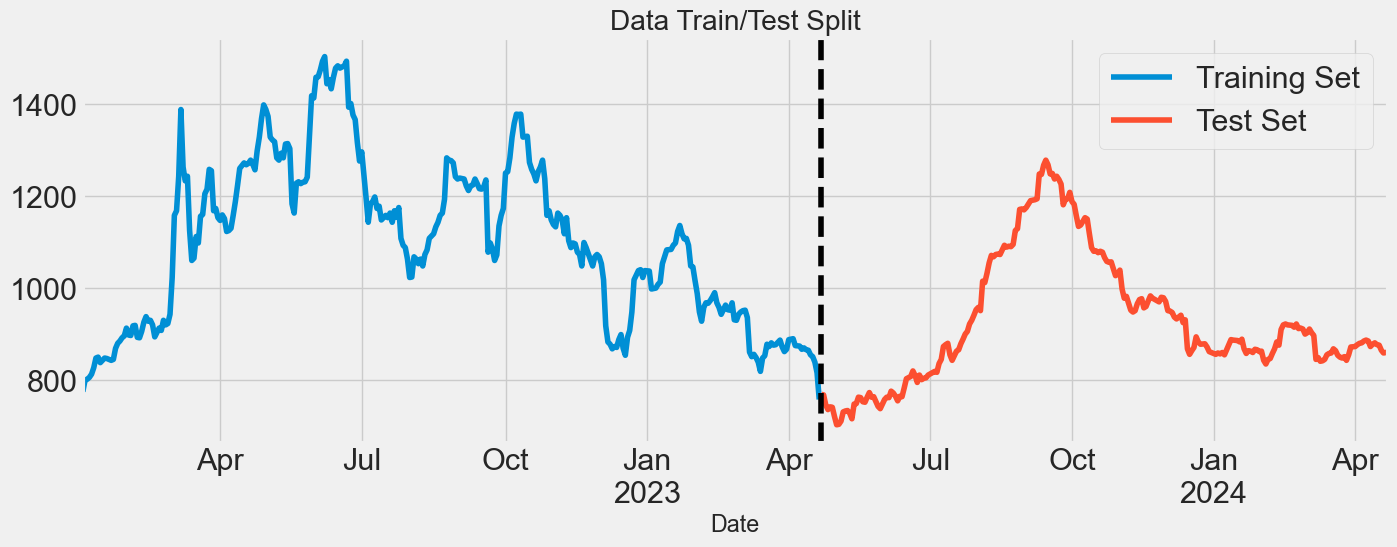

In [4]:
fig, ax = plt.subplots(figsize=(15, 5))
train_val.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(test_start_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [5]:
train_val['Year'] = train_val.index.year
train_val['Quarter'] = train_val.index.quarter
train_val['Month'] = train_val.index.month
train_val['Dayofweek'] = train_val.index.dayofweek
train_val['Dayofmonth'] = train_val.index.day
train_val['Weekofyear'] = train_val.index.isocalendar().week
train_val['Dayofyear'] = train_val.index.dayofyear

test['Year'] = test.index.year
test['Quarter'] = test.index.quarter
test['Month'] = test.index.month
test['Dayofweek'] = test.index.dayofweek
test['Dayofmonth'] = test.index.day
test['Weekofyear'] = test.index.isocalendar().week
test['Dayofyear'] = test.index.dayofyear

In [6]:
def add_business_day_lags(df: pd.DataFrame, col_name: str, lag_days_list: list) -> pd.DataFrame:
    for days in lag_days_list:
        df[f'{col_name}_lag{days}'] = df[col_name].shift(days)
    df = df.fillna(method='bfill').fillna(method='ffill')
    return df

lag_days_list = [10, 20, 60, 120]

train_val = add_business_day_lags(train_val, 'Marine Gasoil 9_Price', lag_days_list)
test = add_business_day_lags(test, 'Marine Gasoil 9_Price', lag_days_list)

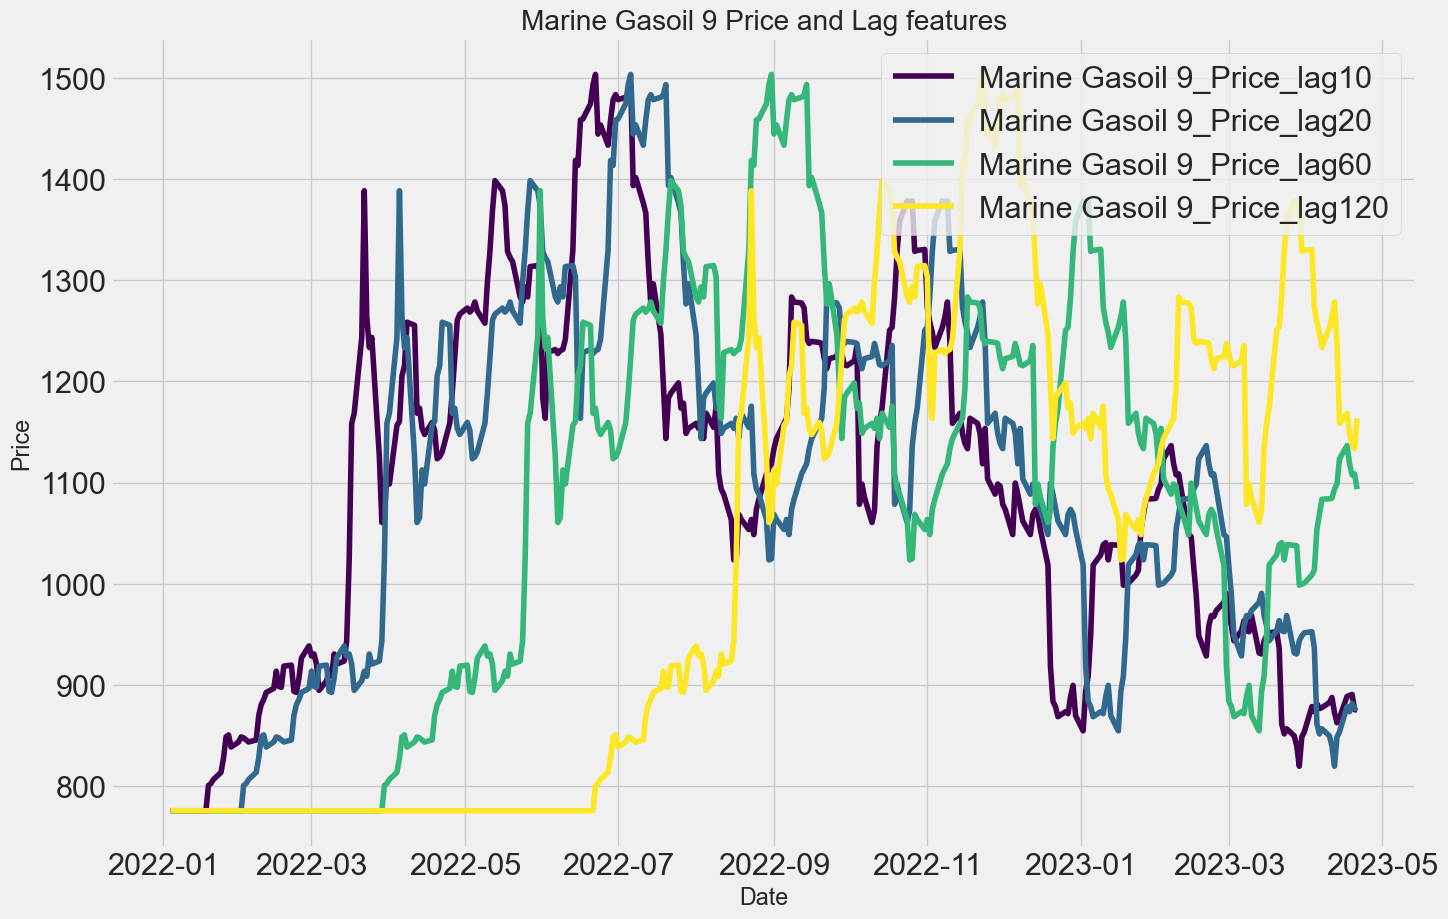

In [7]:
columns_to_plot = [
    'Marine Gasoil 9_Price_lag10',
    'Marine Gasoil 9_Price_lag20',
    'Marine Gasoil 9_Price_lag60',
    'Marine Gasoil 9_Price_lag120'
    ]

cmap = plt.cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(columns_to_plot)))

plt.figure(figsize=(15, 10))

for col, color in zip(columns_to_plot, colors):
    plt.plot(train_val.index, train_val[col], label=col, color=color)

plt.title('Marine Gasoil 9 Price and Lag features')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

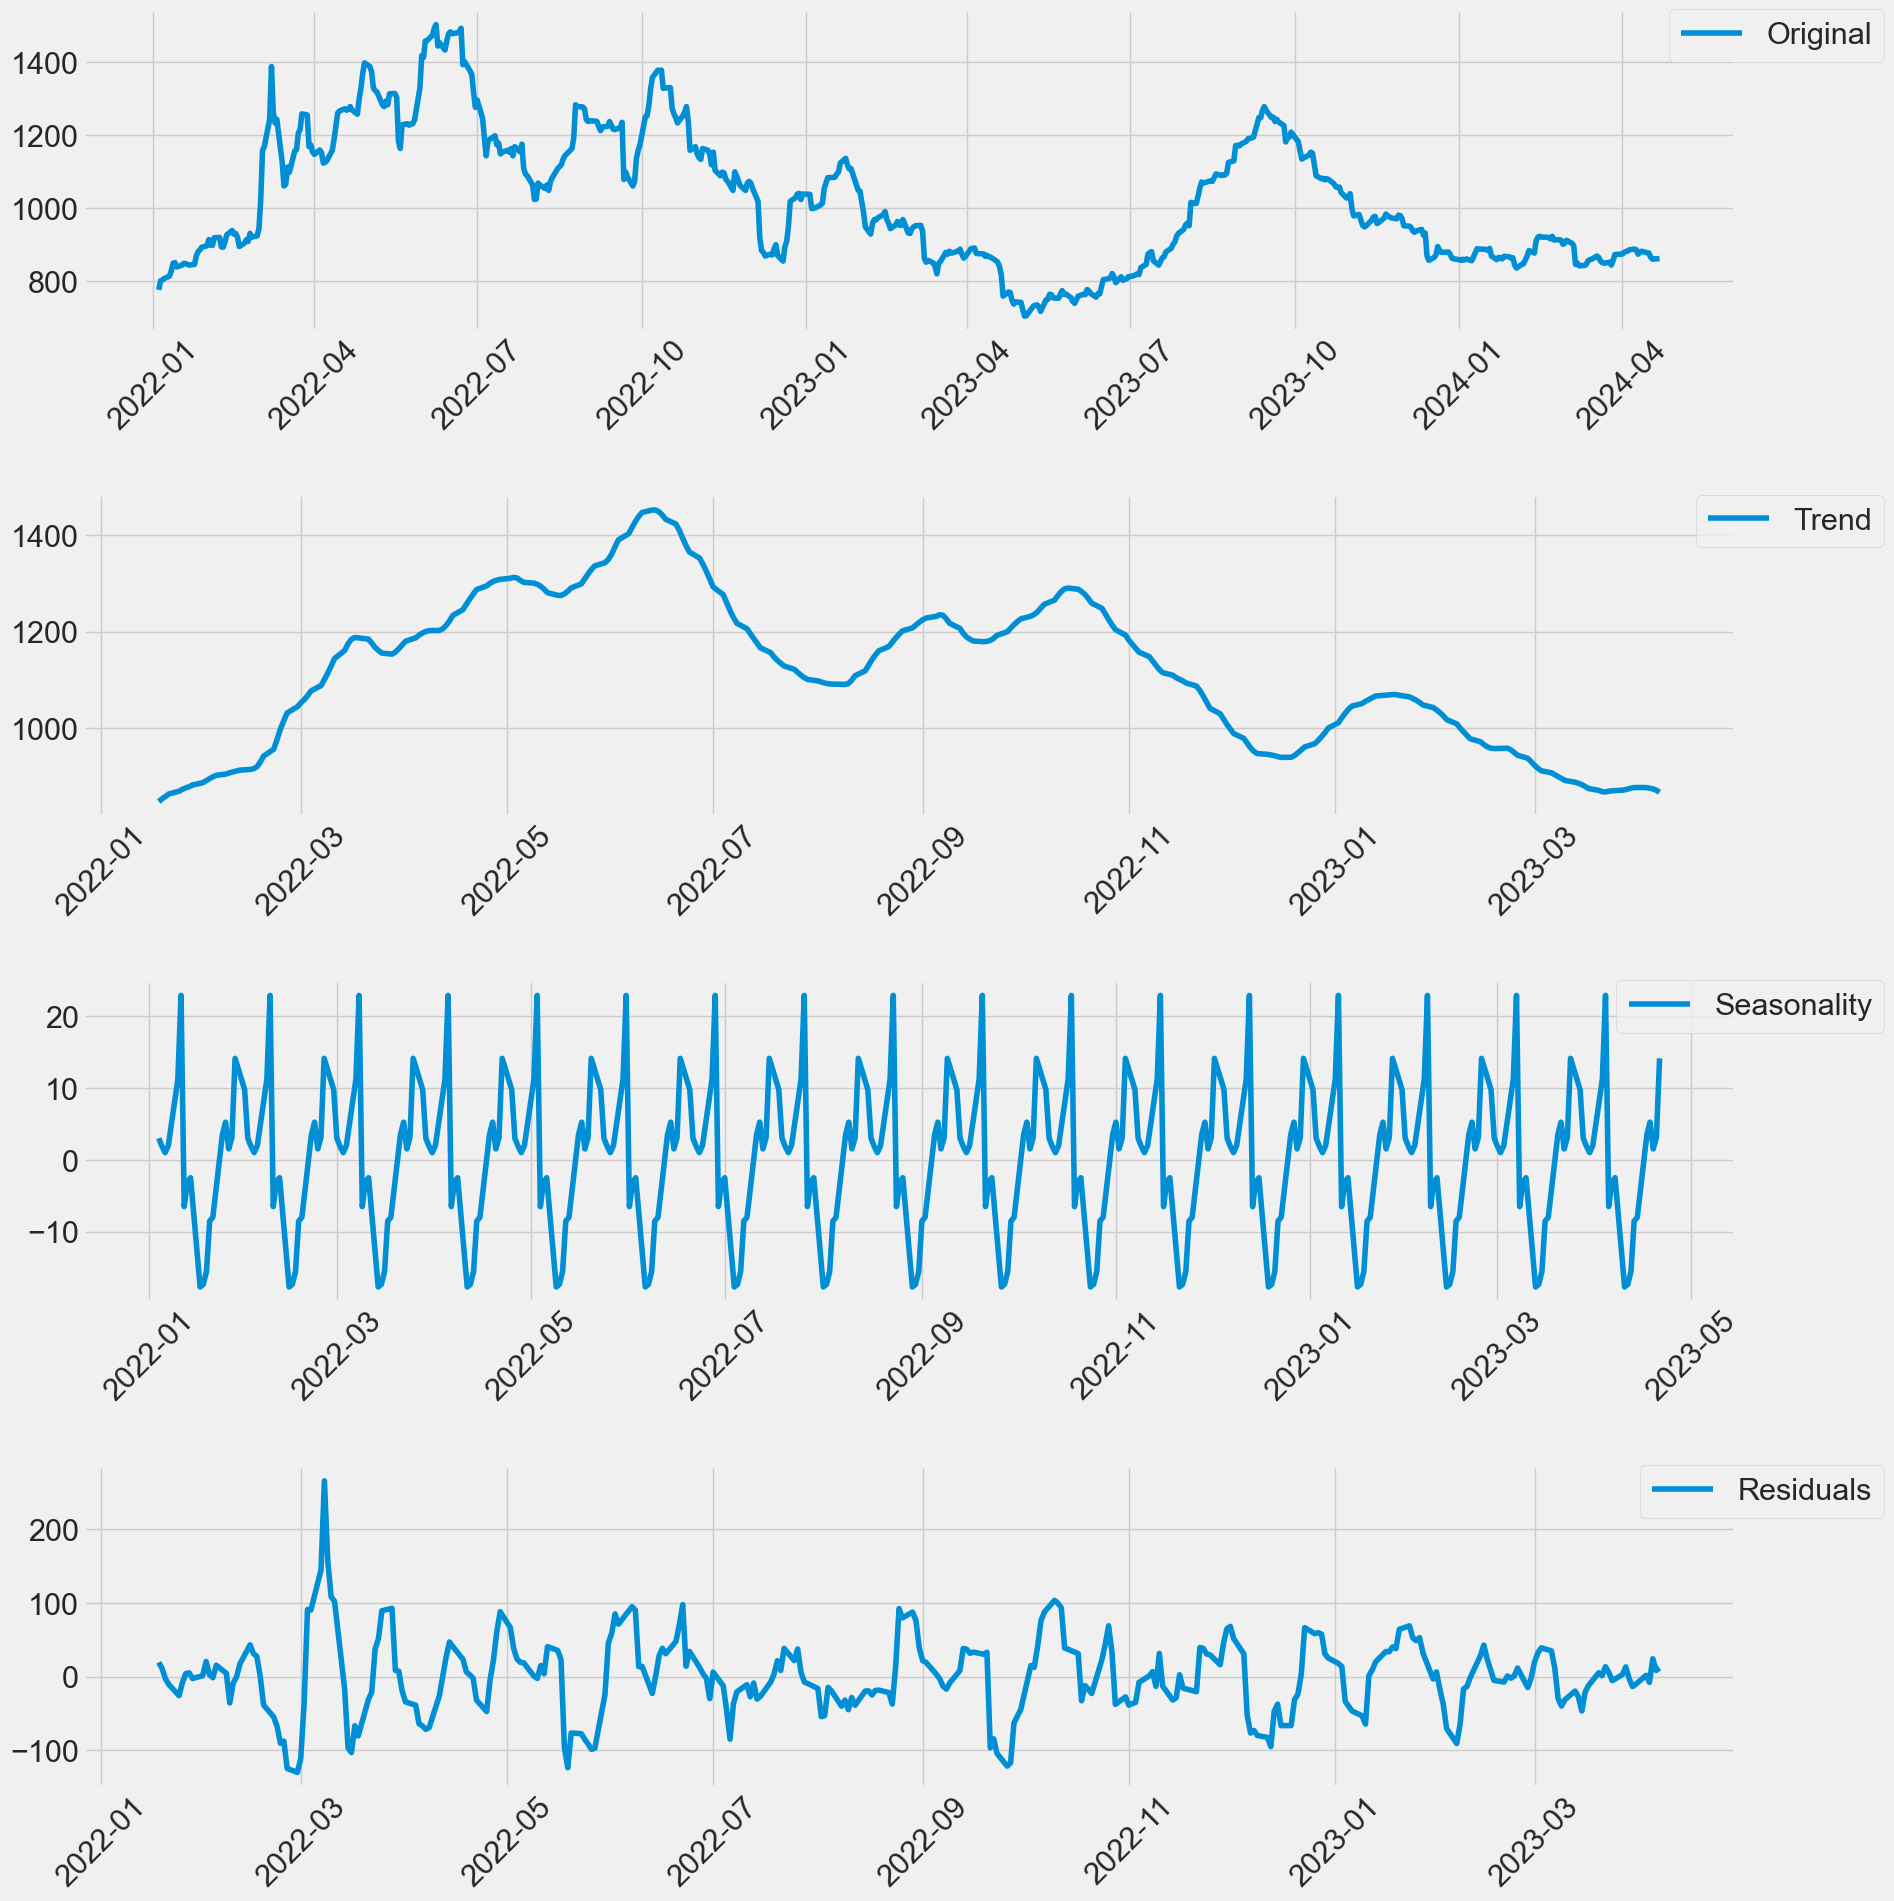

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(train_val['Marine Gasoil 9_Price'], period=20)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본 - 추세 - 계절성

plt.rcParams["figure.figsize"] = (20, 20)
plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout(pad=3.0)
plt.show()

In [9]:
train_val['trend'] = trend
train_val['seasonal'] = seasonal
train_val.head(30)

Marine Gasoil 9_Price  Year  Quarter  Month  Dayofweek  \
Date                                                                 
2022-01-04                  775.5  2022        1      1          1   
2022-01-05                  800.5  2022        1      1          2   
2022-01-06                  802.5  2022        1      1          3   
2022-01-07                  806.5  2022        1      1          4   
2022-01-10                  813.5  2022        1      1          0   
2022-01-11                  827.5  2022        1      1          1   
2022-01-12                  848.5  2022        1      1          2   
2022-01-13                  850.5  2022        1      1          3   
2022-01-14                  838.5  2022        1      1          4   
2022-01-17                  843.5  2022        1      1          0   
2022-01-18                  848.5  2022        1      1          1   
2022-01-19                  847.5  2022        1      1          2   
2022-01-20                  845.5  2022        1      1          3   
2022-01-21                  843.5  2022        1      1          4   
2022-01-24                  845.5  2022        1      1          0   
2022-01-25                  869.5  2022        1      1          1   
2022-01-26                  880.5  2022        1      1          2   
2022-01-27                  885.5  2022        1      1          3   
2022-01-28                  892.5  2022        1      1          4   
2022-01-31                  896.5  2022        1      1          0   
2022-02-01                  913.5  2022        1      2          1   
2022-02-02                  898.5  2022        1      2          2   
2022-02-03                  897.5  2022        1      2          3   
2022-02-04                  918.5  2022        1      2          4   
2022-02-07                  919.5  2022        1      2          0   
2022-02-08                  893.5  2022        1      2          1   
2022-02-09                  892.5  2022        1      2          2   
2022-02-10                  906.5  2022        1      2          3   
2022-02-11                  926.5  2022        1      2          4   
2022-02-14                  938.5  2022        1      2          0   

            Dayofmonth  Weekofyear  Dayofyear  Marine Gasoil 9_Price_lag10  \
Date                                                                         
2022-01-04           4           1          4                        775.5   
2022-01-05           5           1          5                        775.5   
2022-01-06           6           1          6                        775.5   
2022-01-07           7           1          7                        775.5   
2022-01-10          10           2         10                        775.5   
2022-01-11          11           2         11                        775.5   
2022-01-12          12           2         12                        775.5   
2022-01-13          13           2         13                        775.5   
2022-01-14          14           2         14                        775.5   
2022-01-17          17           3         17                        775.5   
2022-01-18          18           3         18                        775.5   
2022-01-19          19           3         19                        800.5   
2022-01-20          20           3         20                        802.5   
2022-01-21          21           3         21                        806.5   
2022-01-24          24           4         24                        813.5   
2022-01-25          25           4         25                        827.5   
2022-01-26          26           4         26                        848.5   
2022-01-27          27           4         27                        850.5   
2022-01-28          28           4         28                        838.5   
2022-01-31          31           5         31                        843.5   
2022-02-01           1           5         32          

In [10]:
train_val.tail(20)
train_val_dates = train_val.index
train_val_cols = train_val.columns

In [11]:
train_val.shape

(339, 14)

## Exp 1. Recursive

### 365 days

In [12]:
def apply_sliding_window_recursive(train_features, test_index, window_size, current_index=0, full_data=None, extended_features=None, windows=None):
    if full_data is None:
        full_data = train_features.copy()
    if extended_features is None:
        extended_features = {col: [] for col in train_features.columns}
    if windows is None:
        windows = {col: [] for col in train_features.columns}

    if current_index >= len(test_index):
        return extended_features, windows

    test_date = test_index[current_index]
    start_date = test_date - pd.Timedelta(days=window_size)
    
    for col in train_features.columns:
        window_values = full_data[col].loc[start_date:test_date]
        
        if not window_values.empty:
            mean_value = window_values.mean()
            extended_features[col].append(mean_value)
            windows[col].append(window_values)
            full_data.at[test_date, col] = mean_value
        else:
            extended_features[col].append(np.nan)
            windows[col].append(pd.Series(dtype=float))

    return apply_sliding_window_recursive(train_features, test_index, window_size, current_index + 1, full_data, extended_features, windows)

test_dates = test.index
test_cols = test.columns

# Window size 설정
window_size = 365

# Test 데이터에 대해 Trend와 Seasonal feature 적용
extended_features, windows = apply_sliding_window_recursive(train_val[['trend', 'seasonal']], test_dates, window_size)

test['trend'] = extended_features['trend']
test['seasonal'] = extended_features['seasonal']

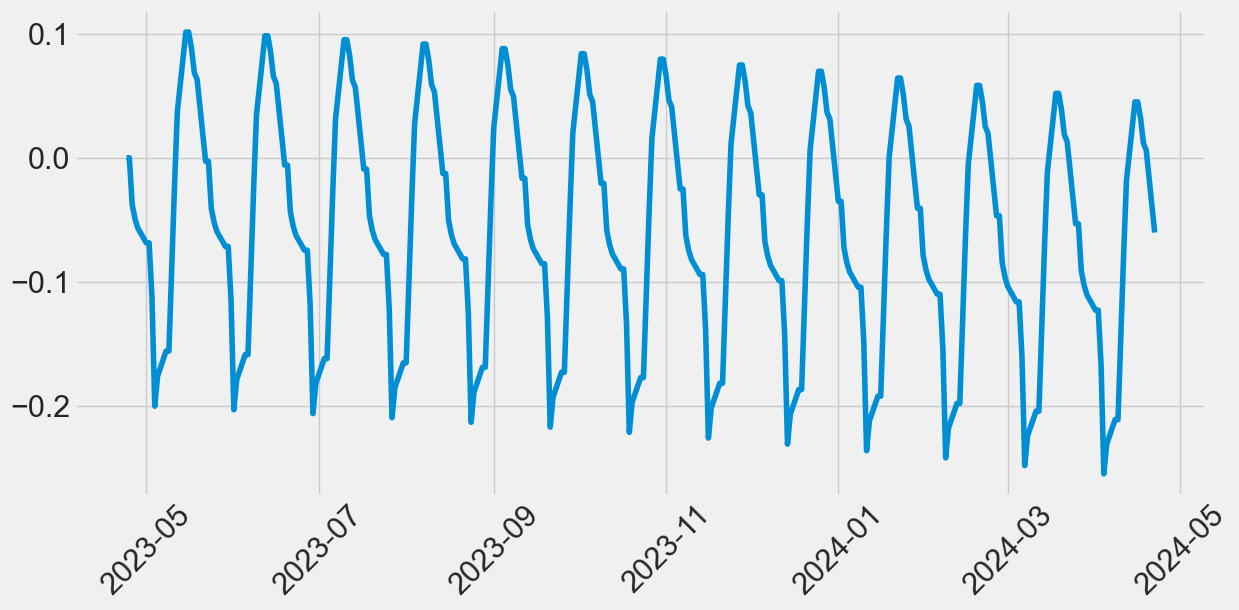

In [13]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6
plt.xticks(rotation=45)
plt.plot(test['seasonal']);

In [14]:
validation_start_date = test_start_date - pd.Timedelta(days=28)  # 주말 제외 20일이 되도록 조정 (주말 제외 한 달)

train = train_val.loc[train_val.index<=validation_start_date]
validation = train_val.loc[(train_val.index > validation_start_date) & (train_val.index <= test_start_date)]

train.shape, validation.shape, test.shape

((319, 14), (20, 14), (261, 14))

In [15]:
train['Weekofyear'] = train['Weekofyear'].astype('int32')
validation['Weekofyear'] = validation['Weekofyear'].astype('int32')
test['Weekofyear'] = test['Weekofyear'].astype('int32')

In [16]:
# 모델 정의
xgb_model = XGBRegressor(
    base_score=0.5, booster='gbtree',
    n_estimators=10000, early_stopping_rounds=50,
    objective='reg:squarederror', max_depth=6,
    learning_rate=0.01, min_child_weight=1,
    subsample=0.8, colsample_bytree=0.8,
    gamma=0, reg_alpha=0, reg_lambda=1,
    random_state=42
)

In [17]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_val = train_val.drop(columns=['Marine Gasoil 9_Price'])
y_train_val = train_val['Marine Gasoil 9_Price']
X_test = test.drop(columns=['Marine Gasoil 9_Price'])
y_test = test['Marine Gasoil 9_Price']

tss = TimeSeriesSplit(n_splits = 5)

mae_scores = []
rmse_scores = []
mape_scores = []

fold = 0
for train_idx, val_idx in tss.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)
    
    y_train_pred = xgb_model.predict(X_train)
    y_val_pred = xgb_model.predict(X_val)
    
    mae_scores.append(mean_absolute_error(y_val, y_val_pred))
    rmse_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))
    mape_scores.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)
    
    fold += 1

[0]	validation_0-rmse:1281.91503
[100]	validation_0-rmse:594.02699
[200]	validation_0-rmse:321.13697
[300]	validation_0-rmse:234.15080
[400]	validation_0-rmse:208.13216
[500]	validation_0-rmse:195.55245
[600]	validation_0-rmse:188.02300
[700]	validation_0-rmse:183.05563
[800]	validation_0-rmse:180.04318
[900]	validation_0-rmse:178.23731
[1000]	validation_0-rmse:177.04844
[1100]	validation_0-rmse:176.40775
[1200]	validation_0-rmse:175.84055
[1300]	validation_0-rmse:175.58073
[1400]	validation_0-rmse:175.36698
[1500]	validation_0-rmse:175.24609
[1600]	validation_0-rmse:175.15093
[1700]	validation_0-rmse:175.08929
[1800]	validation_0-rmse:175.05149
[1900]	validation_0-rmse:175.02520
[2000]	validation_0-rmse:175.00700
[2100]	validation_0-rmse:174.99551
[2200]	validation_0-rmse:174.98826
[2300]	validation_0-rmse:174.97995
[2400]	validation_0-rmse:174.97577
[2500]	validation_0-rmse:174.97324
[2600]	validation_0-rmse:174.97152
[2700]	validation_0-rmse:174.97041
[2800]	validation_0-rmse:174.96

In [18]:
# 성능 평가 지표 출력
print(f'MAE for each fold: {mae_scores}')
print(f'Average MAE across folds: {np.mean(mae_scores):0.2f}')

print(f'RMSE for each fold: {rmse_scores}')
print(f'Average RMSE across folds: {np.mean(rmse_scores):0.2f}')

print(f'MAPE for each fold: {mape_scores}')
print(f'Average MAPE across folds: {np.mean(mape_scores):0.2f}')

MAE for each fold: [149.44769723074776, 96.19344002859933, 44.506665910993306, 138.65599822998047, 37.88909912109375]
Average MAE across folds: 93.34
RMSE for each fold: [174.96796975769865, 115.21204944224395, 58.29274521319043, 163.77544146549891, 45.160544728136976]
Average RMSE across folds: 111.48
MAPE for each fold: [11.20554991937668, 7.87291615280532, 3.666298321473654, 13.83417534117998, 4.225264856091244]
Average MAPE across folds: 8.16


In [19]:
# 최종 모델 학습
xgb_model.fit(X_train, y_train,
                  eval_set = [(X_val, y_val)],
                  verbose=100)

[0]	validation_0-rmse:891.65557
[100]	validation_0-rmse:290.30734
[200]	validation_0-rmse:85.29314
[300]	validation_0-rmse:45.27427
[349]	validation_0-rmse:46.63754


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [20]:
pred_val = xgb_model.predict(X_val)
pred_test = xgb_model.predict(X_test)

pred_val_df = pd.DataFrame(pred_val, index=X_val.index, columns=['prediction_xgb_val_ex1'])
pred_test_df = pd.DataFrame(pred_test, index=X_test.index, columns=['prediction_xgb_ex1'])

ts = ts.merge(pred_val_df, how='left', left_index=True, right_index=True)
ts = ts.merge(pred_test_df, how='left', left_index=True, right_index=True)
ts

Marine Gasoil 9_Price  prediction_xgb_val_ex1  prediction_xgb_ex1
Date                                                                         
2022-01-04                  775.5                     NaN                 NaN
2022-01-05                  800.5                     NaN                 NaN
2022-01-06                  802.5                     NaN                 NaN
2022-01-07                  806.5                     NaN                 NaN
2022-01-10                  813.5                     NaN                 NaN
...                           ...                     ...                 ...
2024-04-16                  876.5                     NaN         1042.510986
2024-04-17                  865.5                     NaN         1041.931396
2024-04-18                  859.5                     NaN         1032.781860
2024-04-19                  860.5                     NaN         1030.054321
2024-04-22                  861.5                     NaN         1032.457520

[600 rows x 3 columns]

#### Prediction

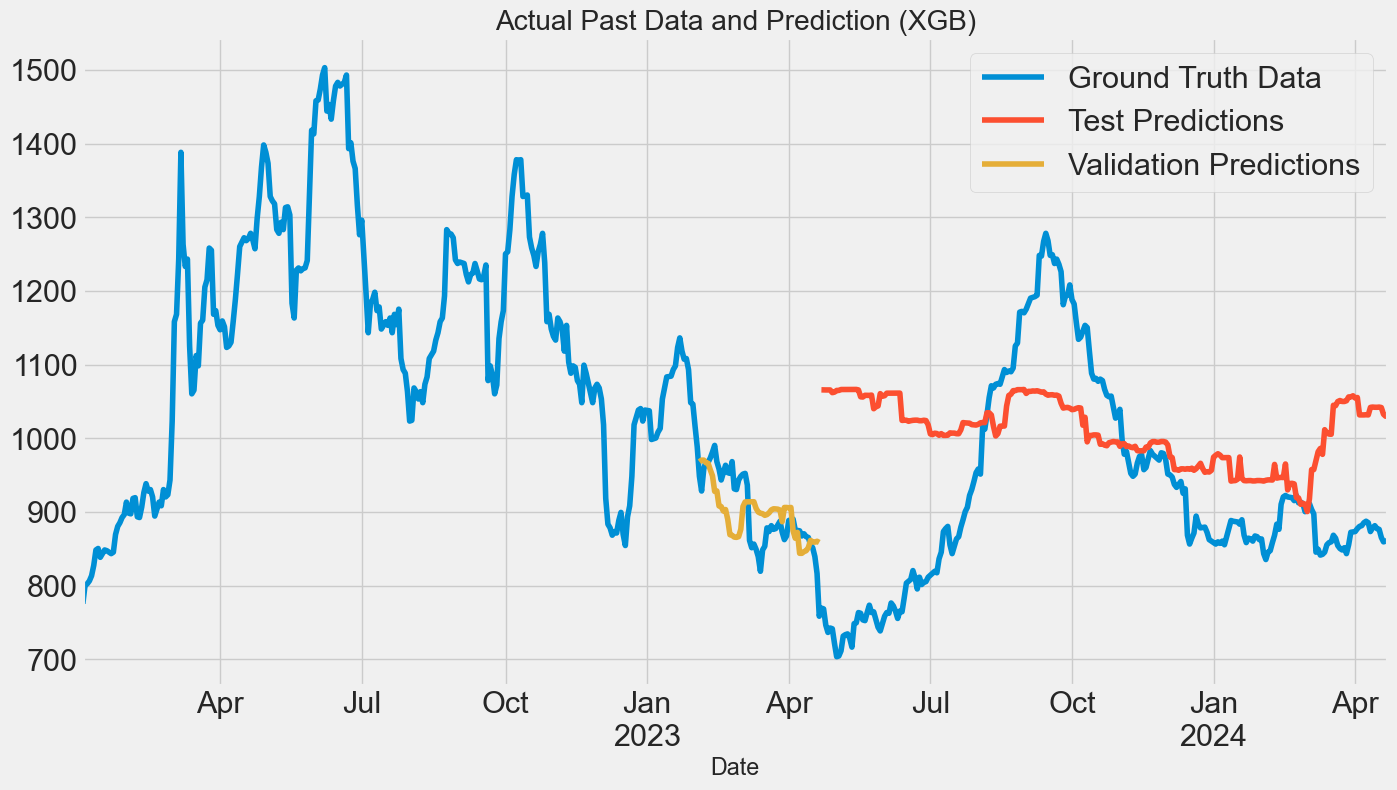

In [21]:
ax = ts['Marine Gasoil 9_Price'].plot(figsize=(15,8))
ts['prediction_xgb_ex1'].plot(ax=ax, style='-')
ts['prediction_xgb_val_ex1'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB)')
plt.show();

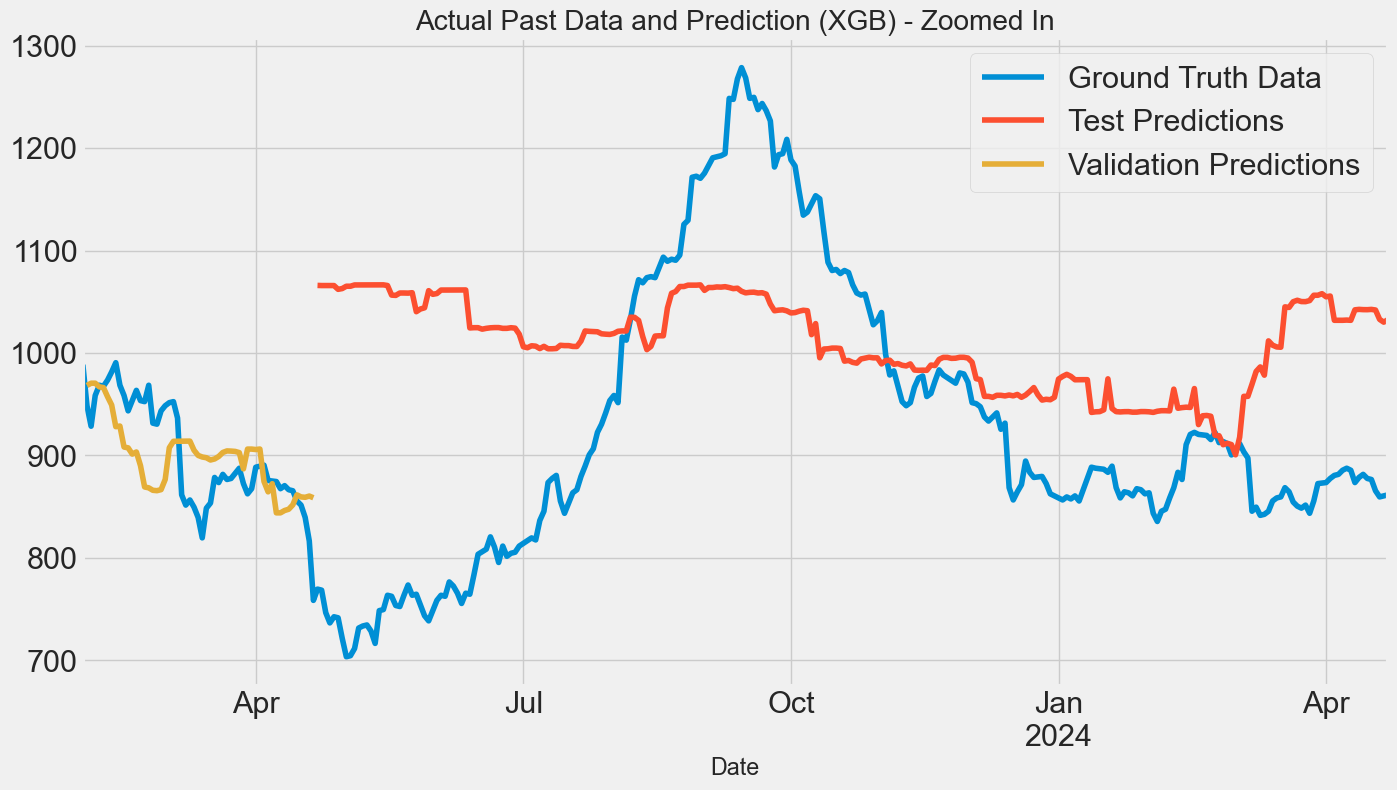

In [22]:
# 특정 날짜 범위를 지정하여 확대
start_date = '2023-02-02'
end_date = '2024-05-01'

# 데이터 필터링
ts_zoomed = ts.loc[start_date:end_date]

# 확대된 범위의 그래프 그리기
ax = ts_zoomed['Marine Gasoil 9_Price'].plot(figsize=(15, 8))
ts_zoomed['prediction_xgb_ex1'].plot(ax=ax, style='-')
ts_zoomed['prediction_xgb_val_ex1'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB) - Zoomed In')
plt.show()

#### MAE, RMSE, MAPE

In [23]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

ts_clean = ts.dropna(subset=['prediction_xgb_val_ex1', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb_val = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_ex1'])
score_rmse_xgb_val = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_ex1']))
score_mape_xgb_val = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_ex1'])

# 결과 출력
print(f'MAE Score on Validation set (XGB): {score_mae_xgb_val:0.2f}')
print(f'RMSE Score on Validation set (XGB): {score_rmse_xgb_val:0.2f}')
print(f'MAPE Score on Validation set (XGB): {score_mape_xgb_val:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (XGB): 37.89
RMSE Score on Validation set (XGB): 45.16
MAPE Score on Validation set (XGB): 4.23%


In [24]:
ts_clean = ts.dropna(subset=['prediction_xgb_ex1', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_ex1'])
score_rmse_xgb = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_ex1']))
score_mape_xgb = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_ex1'])

# 결과 출력
print(f'MAE Score on Test set (XGB): {score_mae_xgb:0.2f}')
print(f'RMSE Score on Test set (XGB): {score_rmse_xgb:0.2f}')
print(f'MAPE Score on Test set (XGB): {score_mape_xgb:.2%}')  # 백분율 형식으로 출력

MAE Score on Test set (XGB): 132.43
RMSE Score on Test set (XGB): 163.13
MAPE Score on Test set (XGB): 15.44%


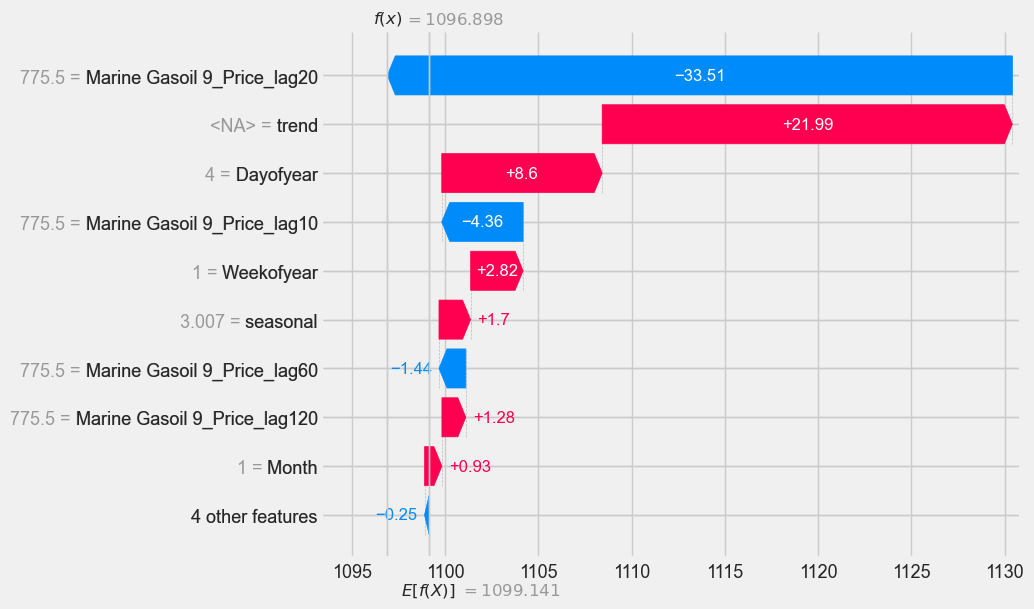

In [25]:
import shap

xgb_explainer = shap.Explainer(xgb_model)
shap_values_xgb = xgb_explainer.shap_values(X_test)

shap.initjs()
shap.waterfall_plot(shap.Explanation(values=shap_values_xgb[0],
                                     base_values=xgb_explainer.expected_value,
                                     data=X_train.iloc[0],
                                     feature_names=X_train.columns.tolist()))

### 182 days

In [26]:
def apply_sliding_window_recursive(train_features, test_index, window_size, current_index=0, full_data=None, extended_features=None, windows=None):
    if full_data is None:
        full_data = train_features.copy()
    if extended_features is None:
        extended_features = {col: [] for col in train_features.columns}
    if windows is None:
        windows = {col: [] for col in train_features.columns}

    if current_index >= len(test_index):
        return extended_features, windows

    test_date = test_index[current_index]
    start_date = test_date - pd.Timedelta(days=window_size)
    
    for col in train_features.columns:
        window_values = full_data[col].loc[start_date:test_date]
        
        if not window_values.empty:
            mean_value = window_values.mean()
            extended_features[col].append(mean_value)
            windows[col].append(window_values)
            full_data.at[test_date, col] = mean_value
        else:
            extended_features[col].append(np.nan)
            windows[col].append(pd.Series(dtype=float))

    return apply_sliding_window_recursive(train_features, test_index, window_size, current_index + 1, full_data, extended_features, windows)

test_dates = test.index
test_cols = test.columns

# Window size 설정
window_size = 182

# Test 데이터에 대해 Trend와 Seasonal feature 적용
extended_features, windows = apply_sliding_window_recursive(train_val[['trend', 'seasonal']], test_dates, window_size)

test['trend'] = extended_features['trend']
test['seasonal'] = extended_features['seasonal']

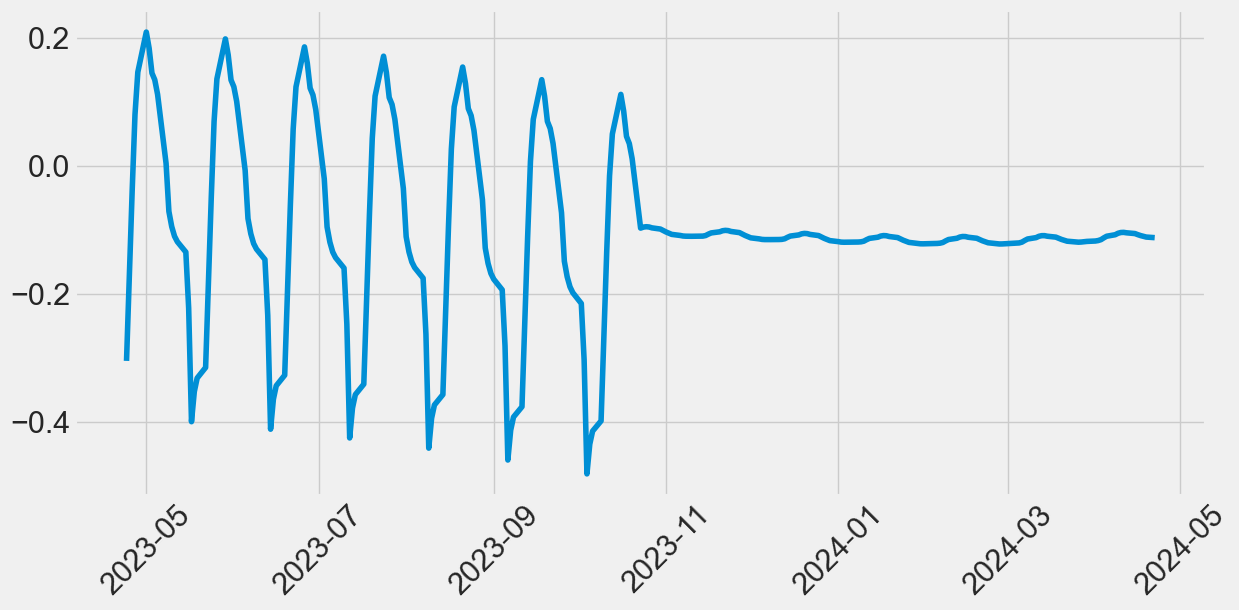

In [27]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6
plt.xticks(rotation=45)
plt.plot(test['seasonal']);

In [28]:
validation_start_date = test_start_date - pd.Timedelta(days=28)  # 주말 제외 20일이 되도록 조정 (주말 제외 한 달)

train = train_val.loc[train_val.index<=validation_start_date]
validation = train_val.loc[(train_val.index > validation_start_date) & (train_val.index <= test_start_date)]

train.shape, validation.shape, test.shape

((319, 14), (20, 14), (261, 14))

In [29]:
train['Weekofyear'] = train['Weekofyear'].astype('int32')
validation['Weekofyear'] = validation['Weekofyear'].astype('int32')
test['Weekofyear'] = test['Weekofyear'].astype('int32')

In [30]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_val = train_val.drop(columns=['Marine Gasoil 9_Price'])
y_train_val = train_val['Marine Gasoil 9_Price']
X_test = test.drop(columns=['Marine Gasoil 9_Price'])
y_test = test['Marine Gasoil 9_Price']

tss = TimeSeriesSplit(n_splits = 5)

mae_scores = []
rmse_scores = []
mape_scores = []

fold = 0
for train_idx, val_idx in tss.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)
    
    y_train_pred = xgb_model.predict(X_train)
    y_val_pred = xgb_model.predict(X_val)
    
    mae_scores.append(mean_absolute_error(y_val, y_val_pred))
    rmse_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))
    mape_scores.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)
    
    fold += 1

[0]	validation_0-rmse:1281.91503
[100]	validation_0-rmse:594.02699
[200]	validation_0-rmse:321.13697
[300]	validation_0-rmse:234.15080
[400]	validation_0-rmse:208.13216
[500]	validation_0-rmse:195.55245
[600]	validation_0-rmse:188.02300
[700]	validation_0-rmse:183.05563
[800]	validation_0-rmse:180.04318
[900]	validation_0-rmse:178.23731
[1000]	validation_0-rmse:177.04844
[1100]	validation_0-rmse:176.40775
[1200]	validation_0-rmse:175.84055
[1300]	validation_0-rmse:175.58073
[1400]	validation_0-rmse:175.36698
[1500]	validation_0-rmse:175.24609
[1600]	validation_0-rmse:175.15093
[1700]	validation_0-rmse:175.08929
[1800]	validation_0-rmse:175.05149
[1900]	validation_0-rmse:175.02520
[2000]	validation_0-rmse:175.00700
[2100]	validation_0-rmse:174.99551
[2200]	validation_0-rmse:174.98826
[2300]	validation_0-rmse:174.97995
[2400]	validation_0-rmse:174.97577
[2500]	validation_0-rmse:174.97324
[2600]	validation_0-rmse:174.97152
[2700]	validation_0-rmse:174.97041
[2800]	validation_0-rmse:174.96

In [31]:
# 성능 평가 지표 출력
print(f'MAE for each fold: {mae_scores}')
print(f'Average MAE across folds: {np.mean(mae_scores):0.2f}')

print(f'RMSE for each fold: {rmse_scores}')
print(f'Average RMSE across folds: {np.mean(rmse_scores):0.2f}')

print(f'MAPE for each fold: {mape_scores}')
print(f'Average MAPE across folds: {np.mean(mape_scores):0.2f}')

MAE for each fold: [149.44769723074776, 96.19344002859933, 44.506665910993306, 138.65599822998047, 37.88909912109375]
Average MAE across folds: 93.34
RMSE for each fold: [174.96796975769865, 115.21204944224395, 58.29274521319043, 163.77544146549891, 45.160544728136976]
Average RMSE across folds: 111.48
MAPE for each fold: [11.20554991937668, 7.87291615280532, 3.666298321473654, 13.83417534117998, 4.225264856091244]
Average MAPE across folds: 8.16


In [32]:
# 최종 모델 학습
xgb_model.fit(X_train, y_train,
                  eval_set = [(X_val, y_val)],
                  verbose=100)

[0]	validation_0-rmse:891.65557
[100]	validation_0-rmse:290.30734
[200]	validation_0-rmse:85.29314
[300]	validation_0-rmse:45.27427
[349]	validation_0-rmse:46.63754


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [33]:
pred_val = xgb_model.predict(X_val)
pred_test = xgb_model.predict(X_test)

pred_val_df = pd.DataFrame(pred_val, index=X_val.index, columns=['prediction_xgb_val_ex2'])
pred_test_df = pd.DataFrame(pred_test, index=X_test.index, columns=['prediction_xgb_ex2'])

ts = ts.merge(pred_val_df, how='left', left_index=True, right_index=True)
ts = ts.merge(pred_test_df, how='left', left_index=True, right_index=True)
ts

Marine Gasoil 9_Price  prediction_xgb_val_ex1  prediction_xgb_ex1  \
Date                                                                            
2022-01-04                  775.5                     NaN                 NaN   
2022-01-05                  800.5                     NaN                 NaN   
2022-01-06                  802.5                     NaN                 NaN   
2022-01-07                  806.5                     NaN                 NaN   
2022-01-10                  813.5                     NaN                 NaN   
...                           ...                     ...                 ...   
2024-04-16                  876.5                     NaN         1042.510986   
2024-04-17                  865.5                     NaN         1041.931396   
2024-04-18                  859.5                     NaN         1032.781860   
2024-04-19                  860.5                     NaN         1030.054321   
2024-04-22                  861.5                     NaN         1032.457520   

            prediction_xgb_val_ex2  prediction_xgb_ex2  
Date                                                    
2022-01-04                     NaN                 NaN  
2022-01-05                     NaN                 NaN  
2022-01-06                     NaN                 NaN  
2022-01-07                     NaN                 NaN  
2022-01-10                     NaN                 NaN  
...                            ...                 ...  
2024-04-16                     NaN          901.393250  
2024-04-17                     NaN          900.813660  
2024-04-18                     NaN          891.913269  
2024-04-19                     NaN          889.490723  
2024-04-22                     NaN          891.893921  

[600 rows x 5 columns]

#### Prediction

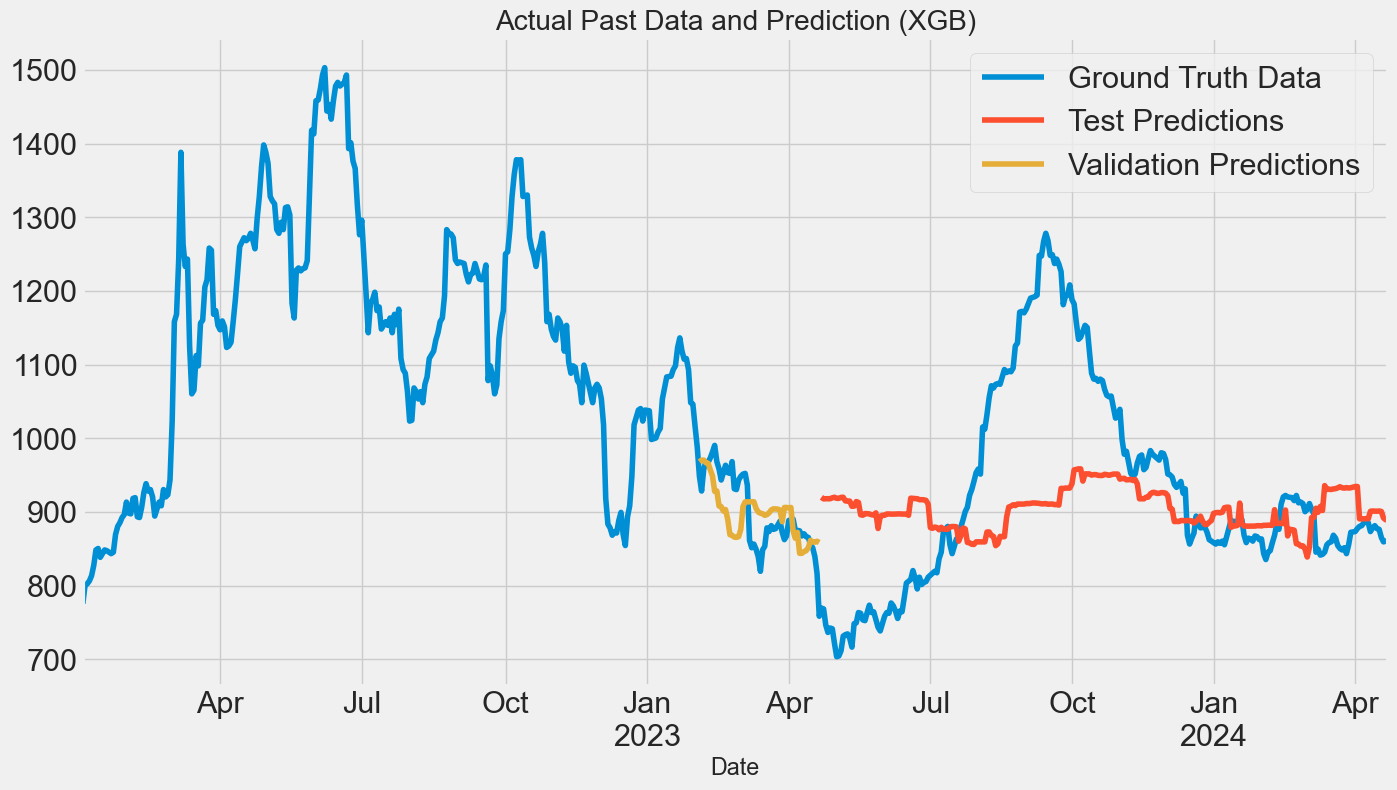

In [34]:
ax = ts['Marine Gasoil 9_Price'].plot(figsize=(15,8))
ts['prediction_xgb_ex2'].plot(ax=ax, style='-')
ts['prediction_xgb_val_ex2'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB)')
plt.show();

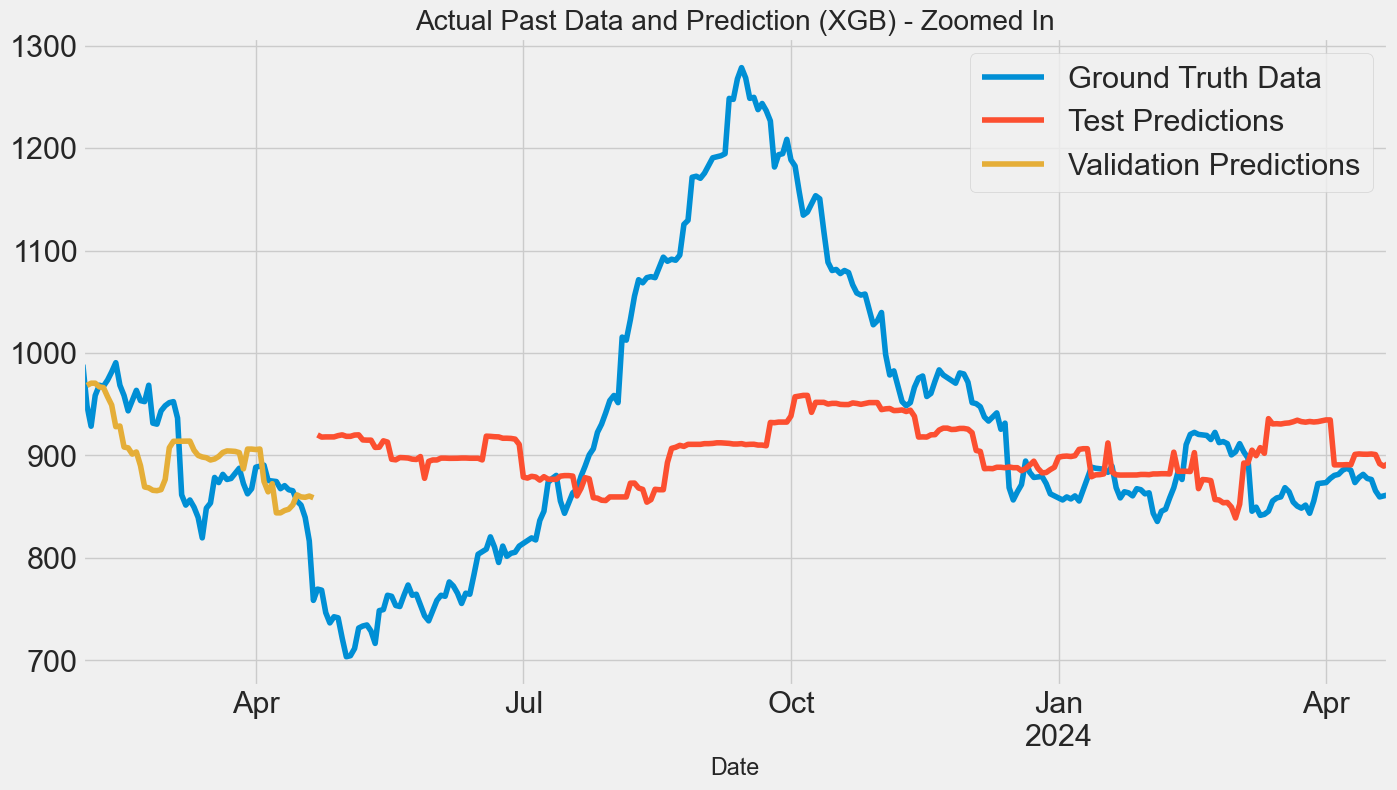

In [35]:
# 특정 날짜 범위를 지정하여 확대
start_date = '2023-02-02'
end_date = '2024-05-01'

# 데이터 필터링
ts_zoomed = ts.loc[start_date:end_date]

# 확대된 범위의 그래프 그리기
ax = ts_zoomed['Marine Gasoil 9_Price'].plot(figsize=(15, 8))
ts_zoomed['prediction_xgb_ex2'].plot(ax=ax, style='-')
ts_zoomed['prediction_xgb_val_ex2'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB) - Zoomed In')
plt.show()

#### MAE, RMSE, MAPE

In [36]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

ts_clean = ts.dropna(subset=['prediction_xgb_val_ex2', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb_val = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_ex2'])
score_rmse_xgb_val = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_ex2']))
score_mape_xgb_val = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_ex2'])

# 결과 출력
print(f'MAE Score on Validation set (XGB): {score_mae_xgb_val:0.2f}')
print(f'RMSE Score on Validation set (XGB): {score_rmse_xgb_val:0.2f}')
print(f'MAPE Score on Validation set (XGB): {score_mape_xgb_val:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (XGB): 37.89
RMSE Score on Validation set (XGB): 45.16
MAPE Score on Validation set (XGB): 4.23%


In [37]:
ts_clean = ts.dropna(subset=['prediction_xgb_ex2', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_ex2'])
score_rmse_xgb = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_ex2']))
score_mape_xgb = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_ex2'])

# 결과 출력
print(f'MAE Score on Test set (XGB): {score_mae_xgb:0.2f}')
print(f'RMSE Score on Test set (XGB): {score_rmse_xgb:0.2f}')
print(f'MAPE Score on Test set (XGB): {score_mape_xgb:.2%}')  # 백분율 형식으로 출력

MAE Score on Test set (XGB): 102.52
RMSE Score on Test set (XGB): 135.59
MAPE Score on Test set (XGB): 10.69%


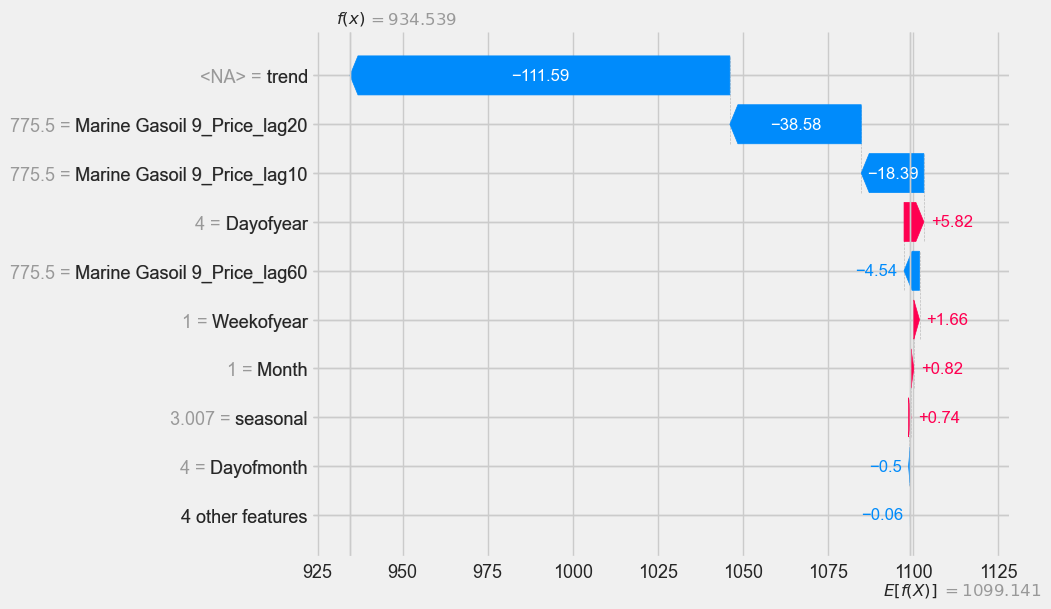

In [38]:
import shap

xgb_explainer = shap.Explainer(xgb_model)
shap_values_xgb = xgb_explainer.shap_values(X_test)

shap.initjs()
shap.waterfall_plot(shap.Explanation(values=shap_values_xgb[0],
                                     base_values=xgb_explainer.expected_value,
                                     data=X_train.iloc[0],
                                     feature_names=X_train.columns.tolist()))

### 91 days

In [39]:
def apply_sliding_window_recursive(train_features, test_index, window_size, current_index=0, full_data=None, extended_features=None, windows=None):
    if full_data is None:
        full_data = train_features.copy()
    if extended_features is None:
        extended_features = {col: [] for col in train_features.columns}
    if windows is None:
        windows = {col: [] for col in train_features.columns}

    if current_index >= len(test_index):
        return extended_features, windows

    test_date = test_index[current_index]
    start_date = test_date - pd.Timedelta(days=window_size)
    
    for col in train_features.columns:
        window_values = full_data[col].loc[start_date:test_date]
        
        if not window_values.empty:
            mean_value = window_values.mean()
            extended_features[col].append(mean_value)
            windows[col].append(window_values)
            full_data.at[test_date, col] = mean_value
        else:
            extended_features[col].append(np.nan)
            windows[col].append(pd.Series(dtype=float))

    return apply_sliding_window_recursive(train_features, test_index, window_size, current_index + 1, full_data, extended_features, windows)

test_dates = test.index
test_cols = test.columns

# Window size 설정
window_size = 91

# Test 데이터에 대해 Trend와 Seasonal feature 적용
extended_features, windows = apply_sliding_window_recursive(train_val[['trend', 'seasonal']], test_dates, window_size)

test['trend'] = extended_features['trend']
test['seasonal'] = extended_features['seasonal']

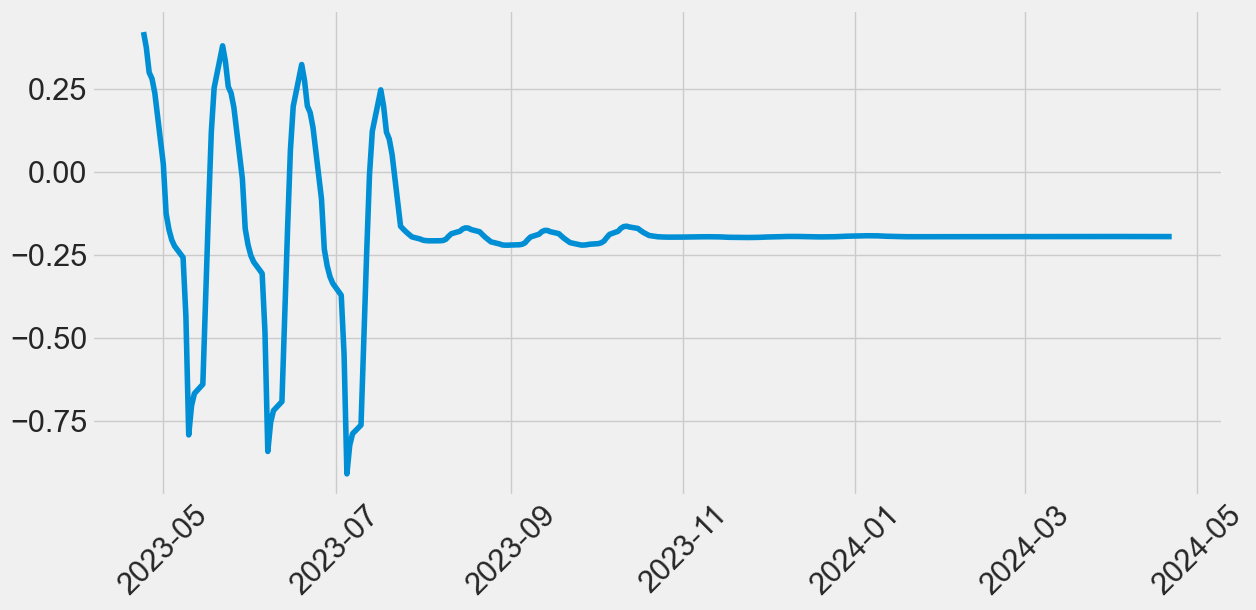

In [40]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6
plt.xticks(rotation=45)
plt.plot(test['seasonal']);

In [41]:
validation_start_date = test_start_date - pd.Timedelta(days=28)  # 주말 제외 20일이 되도록 조정 (주말 제외 한 달)

train = train_val.loc[train_val.index<=validation_start_date]
validation = train_val.loc[(train_val.index > validation_start_date) & (train_val.index <= test_start_date)]

train.shape, validation.shape, test.shape

((319, 14), (20, 14), (261, 14))

In [42]:
train['Weekofyear'] = train['Weekofyear'].astype('int32')
validation['Weekofyear'] = validation['Weekofyear'].astype('int32')
test['Weekofyear'] = test['Weekofyear'].astype('int32')

In [43]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_val = train_val.drop(columns=['Marine Gasoil 9_Price'])
y_train_val = train_val['Marine Gasoil 9_Price']
X_test = test.drop(columns=['Marine Gasoil 9_Price'])
y_test = test['Marine Gasoil 9_Price']

tss = TimeSeriesSplit(n_splits = 5)

mae_scores = []
rmse_scores = []
mape_scores = []

fold = 0
for train_idx, val_idx in tss.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)
    
    y_train_pred = xgb_model.predict(X_train)
    y_val_pred = xgb_model.predict(X_val)
    
    mae_scores.append(mean_absolute_error(y_val, y_val_pred))
    rmse_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))
    mape_scores.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)
    
    fold += 1

[0]	validation_0-rmse:1281.91503
[100]	validation_0-rmse:594.02699
[200]	validation_0-rmse:321.13697
[300]	validation_0-rmse:234.15080
[400]	validation_0-rmse:208.13216
[500]	validation_0-rmse:195.55245
[600]	validation_0-rmse:188.02300
[700]	validation_0-rmse:183.05563
[800]	validation_0-rmse:180.04318
[900]	validation_0-rmse:178.23731
[1000]	validation_0-rmse:177.04844
[1100]	validation_0-rmse:176.40775
[1200]	validation_0-rmse:175.84055
[1300]	validation_0-rmse:175.58073
[1400]	validation_0-rmse:175.36698
[1500]	validation_0-rmse:175.24609
[1600]	validation_0-rmse:175.15093
[1700]	validation_0-rmse:175.08929
[1800]	validation_0-rmse:175.05149
[1900]	validation_0-rmse:175.02520
[2000]	validation_0-rmse:175.00700
[2100]	validation_0-rmse:174.99551
[2200]	validation_0-rmse:174.98826
[2300]	validation_0-rmse:174.97995
[2400]	validation_0-rmse:174.97577
[2500]	validation_0-rmse:174.97324
[2600]	validation_0-rmse:174.97152
[2700]	validation_0-rmse:174.97041
[2800]	validation_0-rmse:174.96

In [44]:
# 성능 평가 지표 출력
print(f'MAE for each fold: {mae_scores}')
print(f'Average MAE across folds: {np.mean(mae_scores):0.2f}')

print(f'RMSE for each fold: {rmse_scores}')
print(f'Average RMSE across folds: {np.mean(rmse_scores):0.2f}')

print(f'MAPE for each fold: {mape_scores}')
print(f'Average MAPE across folds: {np.mean(mape_scores):0.2f}')

MAE for each fold: [149.44769723074776, 96.19344002859933, 44.506665910993306, 138.65599822998047, 37.88909912109375]
Average MAE across folds: 93.34
RMSE for each fold: [174.96796975769865, 115.21204944224395, 58.29274521319043, 163.77544146549891, 45.160544728136976]
Average RMSE across folds: 111.48
MAPE for each fold: [11.20554991937668, 7.87291615280532, 3.666298321473654, 13.83417534117998, 4.225264856091244]
Average MAPE across folds: 8.16


In [45]:
pred_val = xgb_model.predict(X_val)
pred_test = xgb_model.predict(X_test)

pred_val_df = pd.DataFrame(pred_val, index=X_val.index, columns=['prediction_xgb_val_ex3'])
pred_test_df = pd.DataFrame(pred_test, index=X_test.index, columns=['prediction_xgb_ex3'])

ts = ts.merge(pred_val_df, how='left', left_index=True, right_index=True)
ts = ts.merge(pred_test_df, how='left', left_index=True, right_index=True)
ts

Marine Gasoil 9_Price  prediction_xgb_val_ex1  prediction_xgb_ex1  \
Date                                                                            
2022-01-04                  775.5                     NaN                 NaN   
2022-01-05                  800.5                     NaN                 NaN   
2022-01-06                  802.5                     NaN                 NaN   
2022-01-07                  806.5                     NaN                 NaN   
2022-01-10                  813.5                     NaN                 NaN   
...                           ...                     ...                 ...   
2024-04-16                  876.5                     NaN         1042.510986   
2024-04-17                  865.5                     NaN         1041.931396   
2024-04-18                  859.5                     NaN         1032.781860   
2024-04-19                  860.5                     NaN         1030.054321   
2024-04-22                  861.5                     NaN         1032.457520   

            prediction_xgb_val_ex2  prediction_xgb_ex2  \
Date                                                     
2022-01-04                     NaN                 NaN   
2022-01-05                     NaN                 NaN   
2022-01-06                     NaN                 NaN   
2022-01-07                     NaN                 NaN   
2022-01-10                     NaN                 NaN   
...                            ...                 ...   
2024-04-16                     NaN          901.393250   
2024-04-17                     NaN          900.813660   
2024-04-18                     NaN          891.913269   
2024-04-19                     NaN          889.490723   
2024-04-22                     NaN          891.893921   

            prediction_xgb_val_ex3  prediction_xgb_ex3  
Date                                                    
2022-01-04                     NaN                 NaN  
2022-01-05                     NaN                 NaN  
2022-01-06                     NaN                 NaN  
2022-01-07                     NaN                 NaN  
2022-01-10                     NaN                 NaN  
...                            ...                 ...  
2024-04-16                     NaN          881.248657  
2024-04-17                     NaN          880.874512  
2024-04-18                     NaN          871.974121  
2024-04-19                     NaN          869.551636  
2024-04-22                     NaN          871.749329  

[600 rows x 7 columns]

#### Prediction

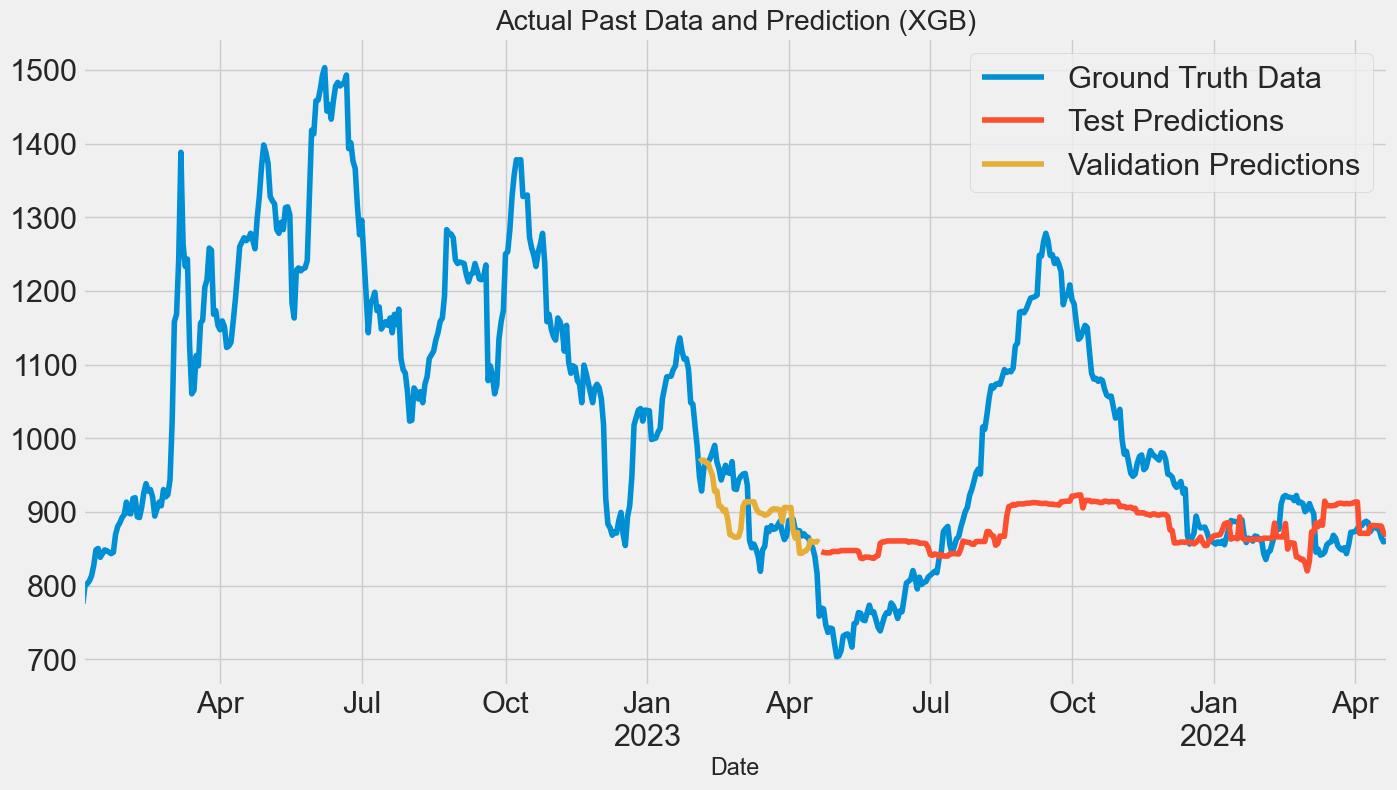

In [46]:
ax = ts['Marine Gasoil 9_Price'].plot(figsize=(15,8))
ts['prediction_xgb_ex3'].plot(ax=ax, style='-')
ts['prediction_xgb_val_ex3'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB)')
plt.show();

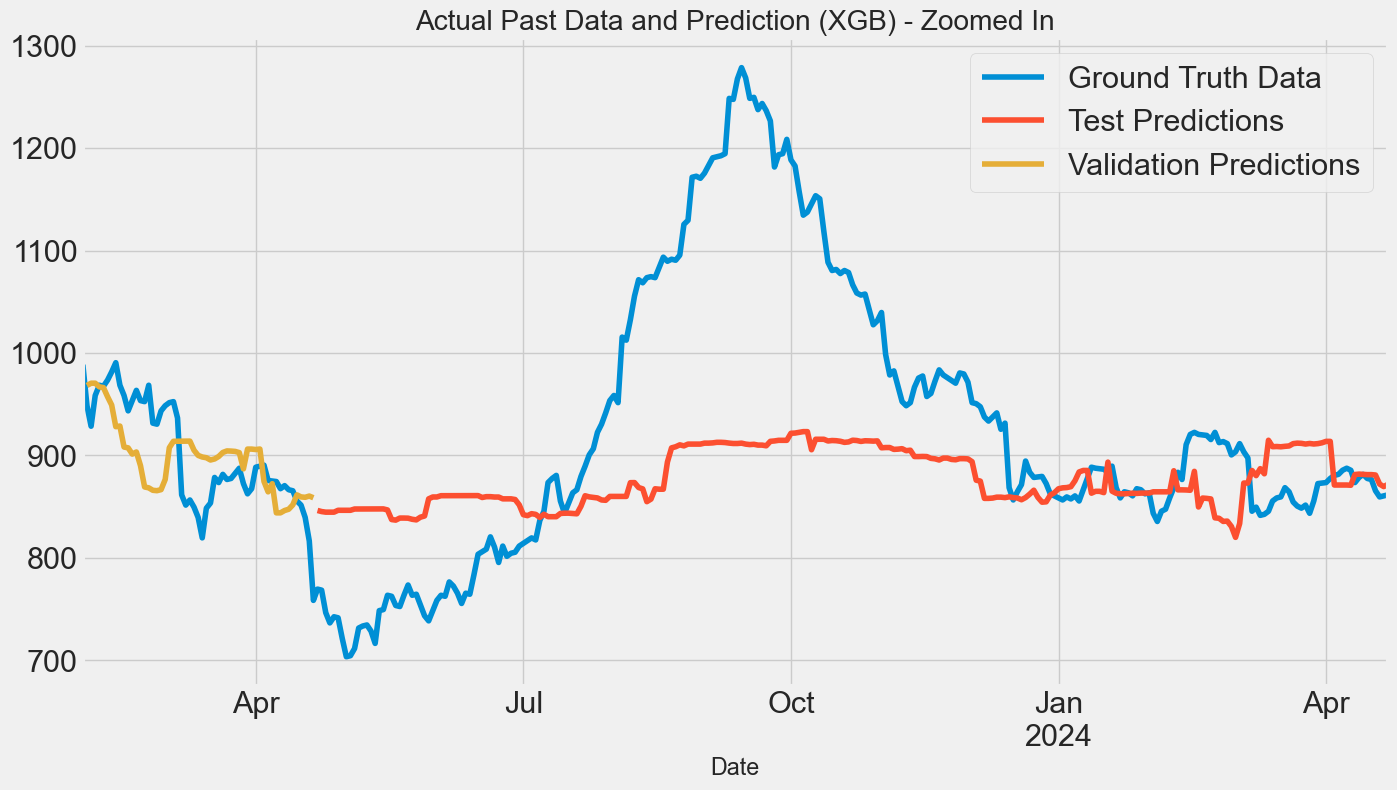

In [47]:
# 특정 날짜 범위를 지정하여 확대
start_date = '2023-02-02'
end_date = '2024-05-01'

# 데이터 필터링
ts_zoomed = ts.loc[start_date:end_date]

# 확대된 범위의 그래프 그리기
ax = ts_zoomed['Marine Gasoil 9_Price'].plot(figsize=(15, 8))
ts_zoomed['prediction_xgb_ex3'].plot(ax=ax, style='-')
ts_zoomed['prediction_xgb_val_ex3'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB) - Zoomed In')
plt.show()

#### MAE, RMSE, MAPE

In [48]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

ts_clean = ts.dropna(subset=['prediction_xgb_val_ex3', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb_val = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_ex3'])
score_rmse_xgb_val = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_ex3']))
score_mape_xgb_val = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_ex3'])

# 결과 출력
print(f'MAE Score on Validation set (XGB): {score_mae_xgb_val:0.2f}')
print(f'RMSE Score on Validation set (XGB): {score_rmse_xgb_val:0.2f}')
print(f'MAPE Score on Validation set (XGB): {score_mape_xgb_val:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (XGB): 37.89
RMSE Score on Validation set (XGB): 45.16
MAPE Score on Validation set (XGB): 4.23%


In [49]:
ts_clean = ts.dropna(subset=['prediction_xgb_ex3', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_ex3'])
score_rmse_xgb = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_ex3']))
score_mape_xgb = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_ex3'])

# 결과 출력
print(f'MAE Score on Test set (XGB): {score_mae_xgb:0.2f}')
print(f'RMSE Score on Test set (XGB): {score_rmse_xgb:0.2f}')
print(f'MAPE Score on Test set (XGB): {score_mape_xgb:.2%}')  # 백분율 형식으로 출력

MAE Score on Test set (XGB): 95.70
RMSE Score on Test set (XGB): 131.01
MAPE Score on Test set (XGB): 9.59%


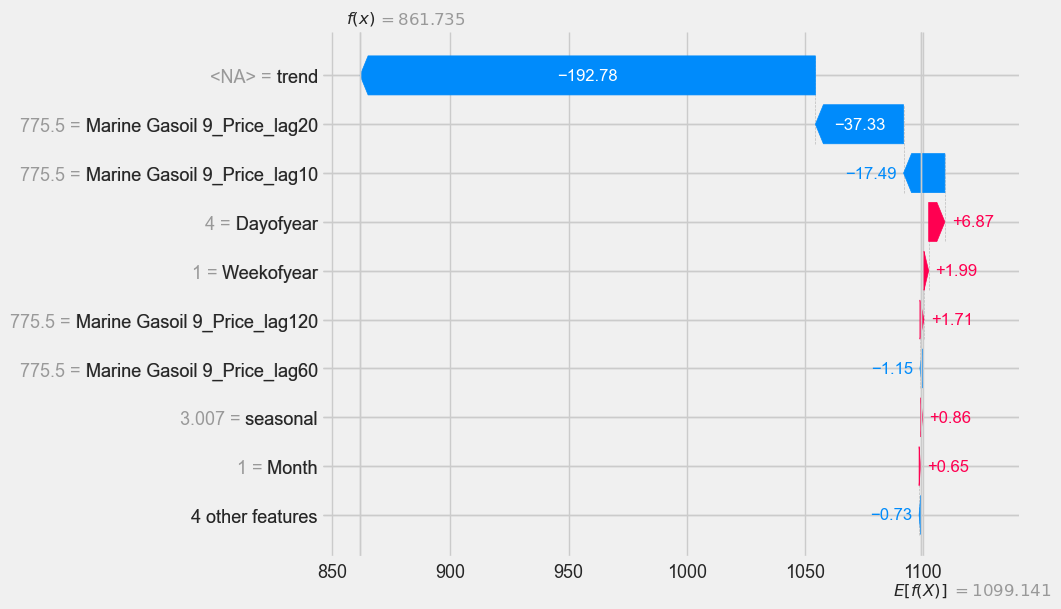

In [50]:
xgb_explainer = shap.Explainer(xgb_model)
shap_values_xgb = xgb_explainer.shap_values(X_test)

shap.initjs()
shap.waterfall_plot(shap.Explanation(values=shap_values_xgb[0],
                                     base_values=xgb_explainer.expected_value,
                                     data=X_train.iloc[0],
                                     feature_names=X_train.columns.tolist()))

### 30 days

In [51]:
def apply_sliding_window_recursive(train_features, test_index, window_size, current_index=0, full_data=None, extended_features=None, windows=None):
    if full_data is None:
        full_data = train_features.copy()
    if extended_features is None:
        extended_features = {col: [] for col in train_features.columns}
    if windows is None:
        windows = {col: [] for col in train_features.columns}

    if current_index >= len(test_index):
        return extended_features, windows

    test_date = test_index[current_index]
    start_date = test_date - pd.Timedelta(days=window_size)
    
    for col in train_features.columns:
        window_values = full_data[col].loc[start_date:test_date]
        
        if not window_values.empty:
            mean_value = window_values.mean()
            extended_features[col].append(mean_value)
            windows[col].append(window_values)
            full_data.at[test_date, col] = mean_value
        else:
            extended_features[col].append(np.nan)
            windows[col].append(pd.Series(dtype=float))

    return apply_sliding_window_recursive(train_features, test_index, window_size, current_index + 1, full_data, extended_features, windows)

test_dates = test.index
test_cols = test.columns

# Window size 설정
window_size = 30

# Test 데이터에 대해 Trend와 Seasonal feature 적용
extended_features, windows = apply_sliding_window_recursive(train_val[['trend', 'seasonal']], test_dates, window_size)

test['trend'] = extended_features['trend']
test['seasonal'] = extended_features['seasonal']

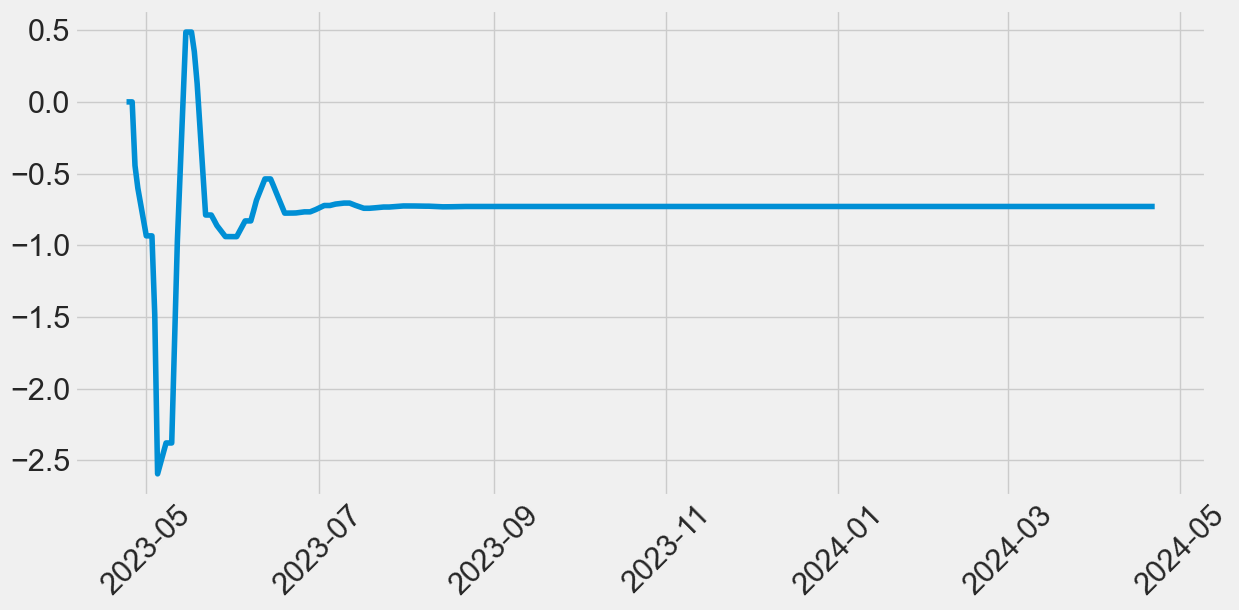

In [52]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6
plt.xticks(rotation=45)
plt.plot(test['seasonal']);

In [53]:
validation_start_date = test_start_date - pd.Timedelta(days=28)  # 주말 제외 20일이 되도록 조정 (주말 제외 한 달)

train = train_val.loc[train_val.index<=validation_start_date]
validation = train_val.loc[(train_val.index > validation_start_date) & (train_val.index <= test_start_date)]

train.shape, validation.shape, test.shape

((319, 14), (20, 14), (261, 14))

In [54]:
train['Weekofyear'] = train['Weekofyear'].astype('int32')
validation['Weekofyear'] = validation['Weekofyear'].astype('int32')
test['Weekofyear'] = test['Weekofyear'].astype('int32')

In [55]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_val = train_val.drop(columns=['Marine Gasoil 9_Price'])
y_train_val = train_val['Marine Gasoil 9_Price']
X_test = test.drop(columns=['Marine Gasoil 9_Price'])
y_test = test['Marine Gasoil 9_Price']

tss = TimeSeriesSplit(n_splits = 5)

mae_scores = []
rmse_scores = []
mape_scores = []

fold = 0
for train_idx, val_idx in tss.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)
    
    y_train_pred = xgb_model.predict(X_train)
    y_val_pred = xgb_model.predict(X_val)
    
    mae_scores.append(mean_absolute_error(y_val, y_val_pred))
    rmse_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))
    mape_scores.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)
    
    fold += 1

[0]	validation_0-rmse:1281.91503
[100]	validation_0-rmse:594.02699
[200]	validation_0-rmse:321.13697
[300]	validation_0-rmse:234.15080
[400]	validation_0-rmse:208.13216
[500]	validation_0-rmse:195.55245
[600]	validation_0-rmse:188.02300
[700]	validation_0-rmse:183.05563
[800]	validation_0-rmse:180.04318
[900]	validation_0-rmse:178.23731
[1000]	validation_0-rmse:177.04844
[1100]	validation_0-rmse:176.40775
[1200]	validation_0-rmse:175.84055
[1300]	validation_0-rmse:175.58073
[1400]	validation_0-rmse:175.36698
[1500]	validation_0-rmse:175.24609
[1600]	validation_0-rmse:175.15093
[1700]	validation_0-rmse:175.08929
[1800]	validation_0-rmse:175.05149
[1900]	validation_0-rmse:175.02520
[2000]	validation_0-rmse:175.00700
[2100]	validation_0-rmse:174.99551
[2200]	validation_0-rmse:174.98826
[2300]	validation_0-rmse:174.97995
[2400]	validation_0-rmse:174.97577
[2500]	validation_0-rmse:174.97324
[2600]	validation_0-rmse:174.97152
[2700]	validation_0-rmse:174.97041
[2800]	validation_0-rmse:174.96

In [56]:
# 성능 평가 지표 출력
print(f'MAE for each fold: {mae_scores}')
print(f'Average MAE across folds: {np.mean(mae_scores):0.2f}')

print(f'RMSE for each fold: {rmse_scores}')
print(f'Average RMSE across folds: {np.mean(rmse_scores):0.2f}')

print(f'MAPE for each fold: {mape_scores}')
print(f'Average MAPE across folds: {np.mean(mape_scores):0.2f}')

MAE for each fold: [149.44769723074776, 96.19344002859933, 44.506665910993306, 138.65599822998047, 37.88909912109375]
Average MAE across folds: 93.34
RMSE for each fold: [174.96796975769865, 115.21204944224395, 58.29274521319043, 163.77544146549891, 45.160544728136976]
Average RMSE across folds: 111.48
MAPE for each fold: [11.20554991937668, 7.87291615280532, 3.666298321473654, 13.83417534117998, 4.225264856091244]
Average MAPE across folds: 8.16


In [57]:
# 최종 모델 학습
xgb_model.fit(X_train, y_train,
                  eval_set = [(X_val, y_val)],
                  verbose=100)

[0]	validation_0-rmse:891.65557
[100]	validation_0-rmse:290.30734
[200]	validation_0-rmse:85.29314
[300]	validation_0-rmse:45.27427
[349]	validation_0-rmse:46.63754


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [58]:
pred_val = xgb_model.predict(X_val)
pred_test = xgb_model.predict(X_test)

pred_val_df = pd.DataFrame(pred_val, index=X_val.index, columns=['prediction_xgb_val_ex4'])
pred_test_df = pd.DataFrame(pred_test, index=X_test.index, columns=['prediction_xgb_ex4'])

ts = ts.merge(pred_val_df, how='left', left_index=True, right_index=True)
ts = ts.merge(pred_test_df, how='left', left_index=True, right_index=True)
ts

Marine Gasoil 9_Price  prediction_xgb_val_ex1  prediction_xgb_ex1  \
Date                                                                            
2022-01-04                  775.5                     NaN                 NaN   
2022-01-05                  800.5                     NaN                 NaN   
2022-01-06                  802.5                     NaN                 NaN   
2022-01-07                  806.5                     NaN                 NaN   
2022-01-10                  813.5                     NaN                 NaN   
...                           ...                     ...                 ...   
2024-04-16                  876.5                     NaN         1042.510986   
2024-04-17                  865.5                     NaN         1041.931396   
2024-04-18                  859.5                     NaN         1032.781860   
2024-04-19                  860.5                     NaN         1030.054321   
2024-04-22                  861.5                     NaN         1032.457520   

            prediction_xgb_val_ex2  prediction_xgb_ex2  \
Date                                                     
2022-01-04                     NaN                 NaN   
2022-01-05                     NaN                 NaN   
2022-01-06                     NaN                 NaN   
2022-01-07                     NaN                 NaN   
2022-01-10                     NaN                 NaN   
...                            ...                 ...   
2024-04-16                     NaN          901.393250   
2024-04-17                     NaN          900.813660   
2024-04-18                     NaN          891.913269   
2024-04-19                     NaN          889.490723   
2024-04-22                     NaN          891.893921   

            prediction_xgb_val_ex3  prediction_xgb_ex3  \
Date                                                     
2022-01-04                     NaN                 NaN   
2022-01-05                     NaN                 NaN   
2022-01-06                     NaN                 NaN   
2022-01-07                     NaN                 NaN   
2022-01-10                     NaN                 NaN   
...                            ...                 ...   
2024-04-16                     NaN          881.248657   
2024-04-17                     NaN          880.874512   
2024-04-18                     NaN          871.974121   
2024-04-19                     NaN          869.551636   
2024-04-22                     NaN          871.749329   

            prediction_xgb_val_ex4  prediction_xgb_ex4  
Date                                                    
2022-01-04                     NaN                 NaN  
2022-01-05                     NaN                 NaN  
2022-01-06                     NaN                 NaN  
2022-01-07                     NaN                 NaN  
2022-01-10                     NaN                 NaN  
...                            ...                 ...  
2024-04-16                     NaN          875.541077  
2024-04-17                     NaN          875.166931  
2024-04-18                     NaN          866.266541  
2024-04-19                     NaN          863.844055  
2024-04-22                     NaN          866.041748  

[600 rows x 9 columns]

#### Prediction

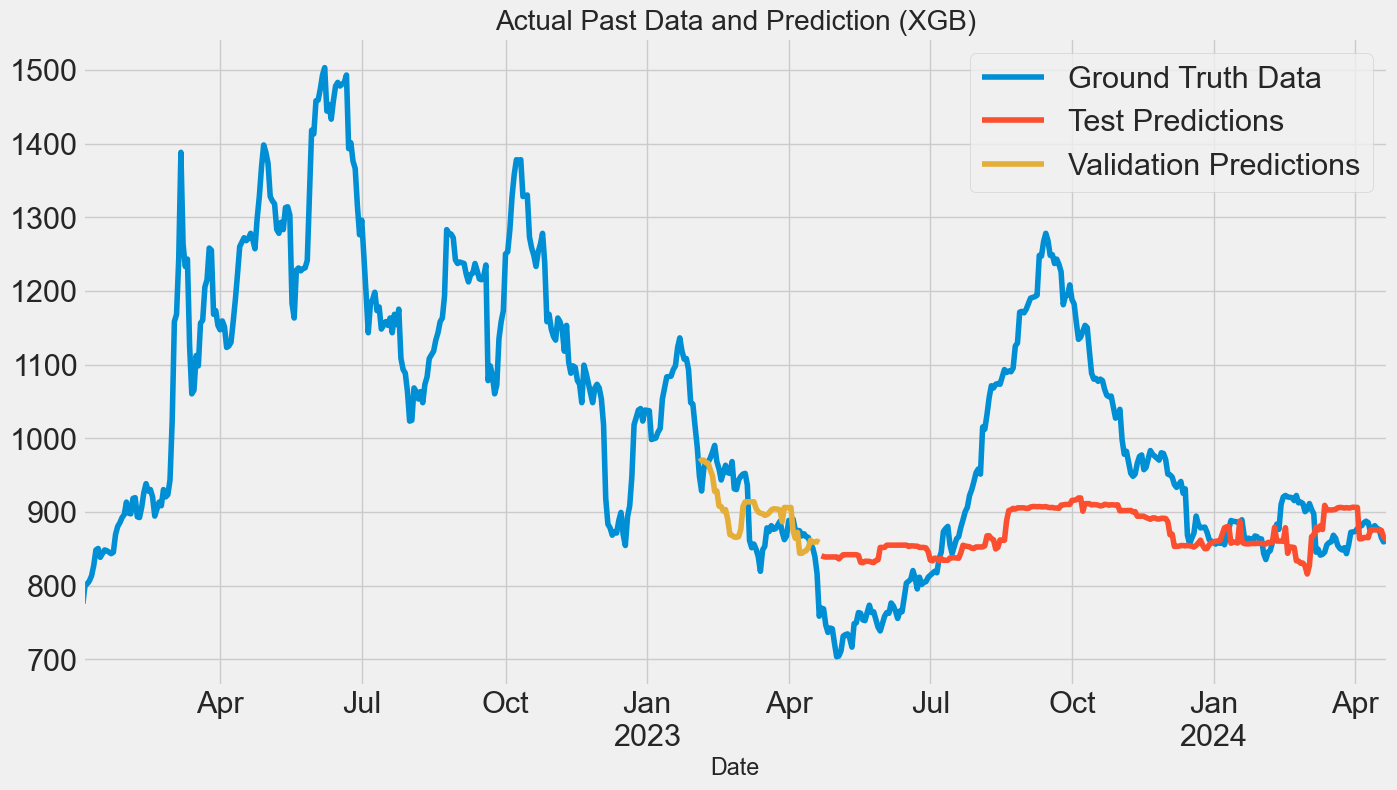

In [59]:
ax = ts['Marine Gasoil 9_Price'].plot(figsize=(15,8))
ts['prediction_xgb_ex4'].plot(ax=ax, style='-')
ts['prediction_xgb_val_ex4'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB)')
plt.show();

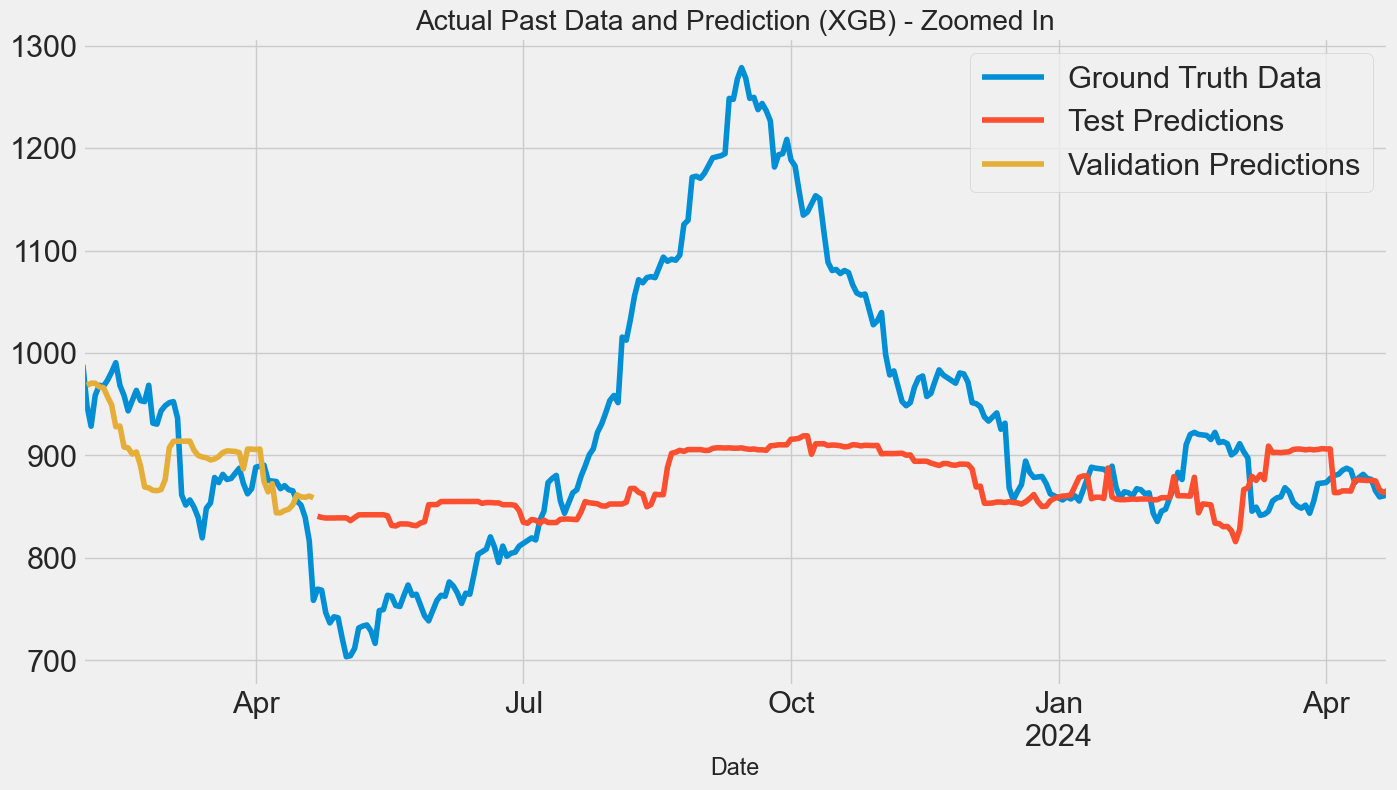

In [60]:
# 특정 날짜 범위를 지정하여 확대
start_date = '2023-02-02'
end_date = '2024-05-01'

# 데이터 필터링
ts_zoomed = ts.loc[start_date:end_date]

# 확대된 범위의 그래프 그리기
ax = ts_zoomed['Marine Gasoil 9_Price'].plot(figsize=(15, 8))
ts_zoomed['prediction_xgb_ex4'].plot(ax=ax, style='-')
ts_zoomed['prediction_xgb_val_ex4'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB) - Zoomed In')
plt.show()

#### MAE, RMSE, MAPE

In [61]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

ts_clean = ts.dropna(subset=['prediction_xgb_val_ex4', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb_val = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_ex4'])
score_rmse_xgb_val = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_ex4']))
score_mape_xgb_val = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_ex4'])

# 결과 출력
print(f'MAE Score on Validation set (XGB): {score_mae_xgb_val:0.2f}')
print(f'RMSE Score on Validation set (XGB): {score_rmse_xgb_val:0.2f}')
print(f'MAPE Score on Validation set (XGB): {score_mape_xgb_val:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (XGB): 37.89
RMSE Score on Validation set (XGB): 45.16
MAPE Score on Validation set (XGB): 4.23%


In [62]:
ts_clean = ts.dropna(subset=['prediction_xgb_ex4', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_ex4'])
score_rmse_xgb = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_ex4']))
score_mape_xgb = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_ex4'])

# 결과 출력
print(f'MAE Score on Test set (XGB): {score_mae_xgb:0.2f}')
print(f'RMSE Score on Test set (XGB): {score_rmse_xgb:0.2f}')
print(f'MAPE Score on Test set (XGB): {score_mape_xgb:.2%}')  # 백분율 형식으로 출력

MAE Score on Test set (XGB): 96.66
RMSE Score on Test set (XGB): 132.91
MAPE Score on Test set (XGB): 9.64%


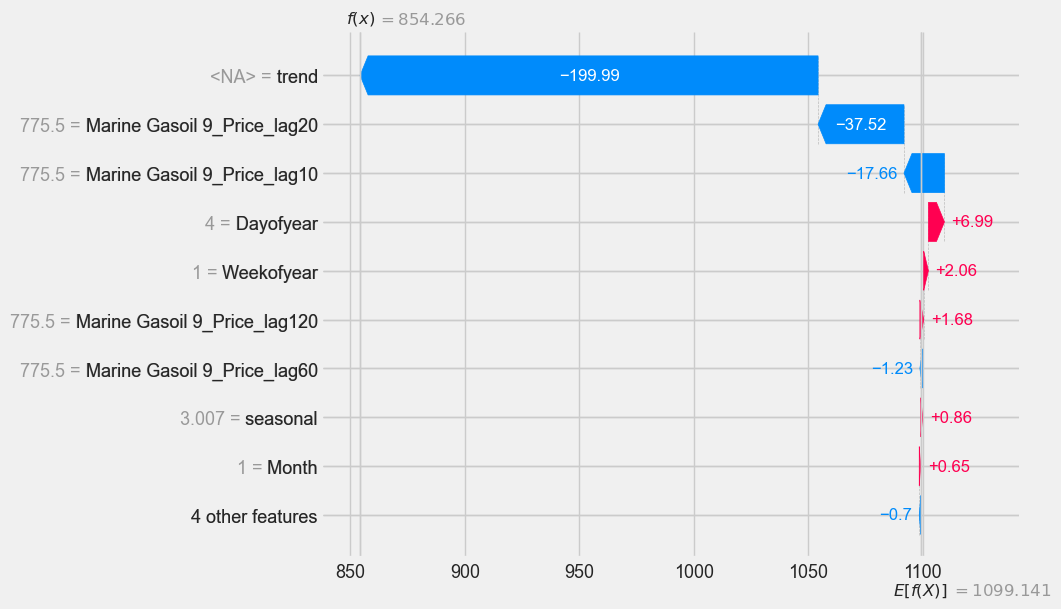

In [63]:
xgb_explainer = shap.Explainer(xgb_model)
shap_values_xgb = xgb_explainer.shap_values(X_test)

shap.initjs()
shap.waterfall_plot(shap.Explanation(values=shap_values_xgb[0],
                                     base_values=xgb_explainer.expected_value,
                                     data=X_train.iloc[0],
                                     feature_names=X_train.columns.tolist()))

## 14 days

In [64]:
def apply_sliding_window_recursive(train_features, test_index, window_size, current_index=0, full_data=None, extended_features=None, windows=None):
    if full_data is None:
        full_data = train_features.copy()
    if extended_features is None:
        extended_features = {col: [] for col in train_features.columns}
    if windows is None:
        windows = {col: [] for col in train_features.columns}

    if current_index >= len(test_index):
        return extended_features, windows

    test_date = test_index[current_index]
    start_date = test_date - pd.Timedelta(days=window_size)
    
    for col in train_features.columns:
        window_values = full_data[col].loc[start_date:test_date]
        
        if not window_values.empty:
            mean_value = window_values.mean()
            extended_features[col].append(mean_value)
            windows[col].append(window_values)
            full_data.at[test_date, col] = mean_value
        else:
            extended_features[col].append(np.nan)
            windows[col].append(pd.Series(dtype=float))

    return apply_sliding_window_recursive(train_features, test_index, window_size, current_index + 1, full_data, extended_features, windows)

test_dates = test.index
test_cols = test.columns

# Window size 설정
window_size = 14

# Test 데이터에 대해 Trend와 Seasonal feature 적용
extended_features, windows = apply_sliding_window_recursive(train_val[['trend', 'seasonal']], test_dates, window_size)

test['trend'] = extended_features['trend']
test['seasonal'] = extended_features['seasonal']

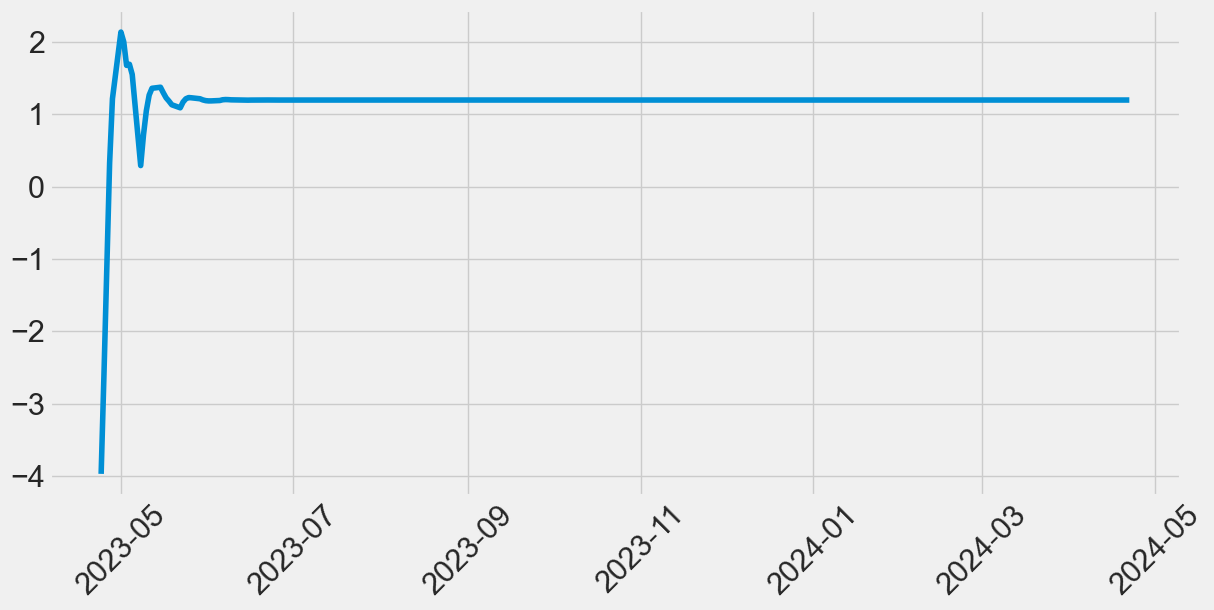

In [65]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6
plt.xticks(rotation=45)
plt.plot(test['seasonal']);

In [66]:
validation_start_date = test_start_date - pd.Timedelta(days=28)  # 주말 제외 20일이 되도록 조정 (주말 제외 한 달)

train = train_val.loc[train_val.index<=validation_start_date]
validation = train_val.loc[(train_val.index > validation_start_date) & (train_val.index <= test_start_date)]

train.shape, validation.shape, test.shape

((319, 14), (20, 14), (261, 14))

In [67]:
train['Weekofyear'] = train['Weekofyear'].astype('int32')
validation['Weekofyear'] = validation['Weekofyear'].astype('int32')
test['Weekofyear'] = test['Weekofyear'].astype('int32')

In [68]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_val = train_val.drop(columns=['Marine Gasoil 9_Price'])
y_train_val = train_val['Marine Gasoil 9_Price']
X_test = test.drop(columns=['Marine Gasoil 9_Price'])
y_test = test['Marine Gasoil 9_Price']

tss = TimeSeriesSplit(n_splits = 5)

mae_scores = []
rmse_scores = []
mape_scores = []

fold = 0
for train_idx, val_idx in tss.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)
    
    y_train_pred = xgb_model.predict(X_train)
    y_val_pred = xgb_model.predict(X_val)
    
    mae_scores.append(mean_absolute_error(y_val, y_val_pred))
    rmse_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))
    mape_scores.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)
    
    fold += 1

[0]	validation_0-rmse:1281.91503
[100]	validation_0-rmse:594.02699
[200]	validation_0-rmse:321.13697
[300]	validation_0-rmse:234.15080
[400]	validation_0-rmse:208.13216
[500]	validation_0-rmse:195.55245
[600]	validation_0-rmse:188.02300
[700]	validation_0-rmse:183.05563
[800]	validation_0-rmse:180.04318
[900]	validation_0-rmse:178.23731
[1000]	validation_0-rmse:177.04844
[1100]	validation_0-rmse:176.40775
[1200]	validation_0-rmse:175.84055
[1300]	validation_0-rmse:175.58073
[1400]	validation_0-rmse:175.36698
[1500]	validation_0-rmse:175.24609
[1600]	validation_0-rmse:175.15093
[1700]	validation_0-rmse:175.08929
[1800]	validation_0-rmse:175.05149
[1900]	validation_0-rmse:175.02520
[2000]	validation_0-rmse:175.00700
[2100]	validation_0-rmse:174.99551
[2200]	validation_0-rmse:174.98826
[2300]	validation_0-rmse:174.97995
[2400]	validation_0-rmse:174.97577
[2500]	validation_0-rmse:174.97324
[2600]	validation_0-rmse:174.97152
[2700]	validation_0-rmse:174.97041
[2800]	validation_0-rmse:174.96

In [69]:
# 성능 평가 지표 출력
print(f'MAE for each fold: {mae_scores}')
print(f'Average MAE across folds: {np.mean(mae_scores):0.2f}')

print(f'RMSE for each fold: {rmse_scores}')
print(f'Average RMSE across folds: {np.mean(rmse_scores):0.2f}')

print(f'MAPE for each fold: {mape_scores}')
print(f'Average MAPE across folds: {np.mean(mape_scores):0.2f}')

MAE for each fold: [149.44769723074776, 96.19344002859933, 44.506665910993306, 138.65599822998047, 37.88909912109375]
Average MAE across folds: 93.34
RMSE for each fold: [174.96796975769865, 115.21204944224395, 58.29274521319043, 163.77544146549891, 45.160544728136976]
Average RMSE across folds: 111.48
MAPE for each fold: [11.20554991937668, 7.87291615280532, 3.666298321473654, 13.83417534117998, 4.225264856091244]
Average MAPE across folds: 8.16


In [70]:
# 최종 모델 학습
xgb_model.fit(X_train, y_train,
                  eval_set = [(X_val, y_val)],
                  verbose=100)

[0]	validation_0-rmse:891.65557
[100]	validation_0-rmse:290.30734
[200]	validation_0-rmse:85.29314
[300]	validation_0-rmse:45.27427
[349]	validation_0-rmse:46.63754


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [71]:
pred_val = xgb_model.predict(X_val)
pred_test = xgb_model.predict(X_test)

pred_val_df = pd.DataFrame(pred_val, index=X_val.index, columns=['prediction_xgb_val_ex5'])
pred_test_df = pd.DataFrame(pred_test, index=X_test.index, columns=['prediction_xgb_ex5'])

ts = ts.merge(pred_val_df, how='left', left_index=True, right_index=True)
ts = ts.merge(pred_test_df, how='left', left_index=True, right_index=True)
ts

Marine Gasoil 9_Price  prediction_xgb_val_ex1  prediction_xgb_ex1  \
Date                                                                            
2022-01-04                  775.5                     NaN                 NaN   
2022-01-05                  800.5                     NaN                 NaN   
2022-01-06                  802.5                     NaN                 NaN   
2022-01-07                  806.5                     NaN                 NaN   
2022-01-10                  813.5                     NaN                 NaN   
...                           ...                     ...                 ...   
2024-04-16                  876.5                     NaN         1042.510986   
2024-04-17                  865.5                     NaN         1041.931396   
2024-04-18                  859.5                     NaN         1032.781860   
2024-04-19                  860.5                     NaN         1030.054321   
2024-04-22                  861.5                     NaN         1032.457520   

            prediction_xgb_val_ex2  prediction_xgb_ex2  \
Date                                                     
2022-01-04                     NaN                 NaN   
2022-01-05                     NaN                 NaN   
2022-01-06                     NaN                 NaN   
2022-01-07                     NaN                 NaN   
2022-01-10                     NaN                 NaN   
...                            ...                 ...   
2024-04-16                     NaN          901.393250   
2024-04-17                     NaN          900.813660   
2024-04-18                     NaN          891.913269   
2024-04-19                     NaN          889.490723   
2024-04-22                     NaN          891.893921   

            prediction_xgb_val_ex3  prediction_xgb_ex3  \
Date                                                     
2022-01-04                     NaN                 NaN   
2022-01-05                     NaN                 NaN   
2022-01-06                     NaN                 NaN   
2022-01-07                     NaN                 NaN   
2022-01-10                     NaN                 NaN   
...                            ...                 ...   
2024-04-16                     NaN          881.248657   
2024-04-17                     NaN          880.874512   
2024-04-18                     NaN          871.974121   
2024-04-19                     NaN          869.551636   
2024-04-22                     NaN          871.749329   

            prediction_xgb_val_ex4  prediction_xgb_ex4  \
Date                                                     
2022-01-04                     NaN                 NaN   
2022-01-05                     NaN                 NaN   
2022-01-06                     NaN                 NaN   
2022-01-07                     NaN                 NaN   
2022-01-10                     NaN                 NaN   
...                            ...                 ...   
2024-04-16                     NaN          875.541077   
2024-04-17                     NaN          875.166931   
2024-04-18                     NaN          866.266541   
2024-04-19                     NaN          863.844055   
2024-04-22                     NaN          866.041748   

            prediction_xgb_val_ex5  prediction_xgb_ex5  
Date                                                    
2022-01-04                     NaN                 NaN  
2022-01-05                     NaN                 NaN  
2022-01-06                     NaN                 NaN  
2022-01-07                     NaN                 NaN  
2022-01-10                     NaN                 NaN  
...                            ...                 ...  
2024-04-16                     NaN          859.089294  
2024-04-17                     NaN          859.089294  
2024-04-18                     NaN          849.692200  
2024-04-19                     NaN          847.544983  
2024-04-2

#### Prediction

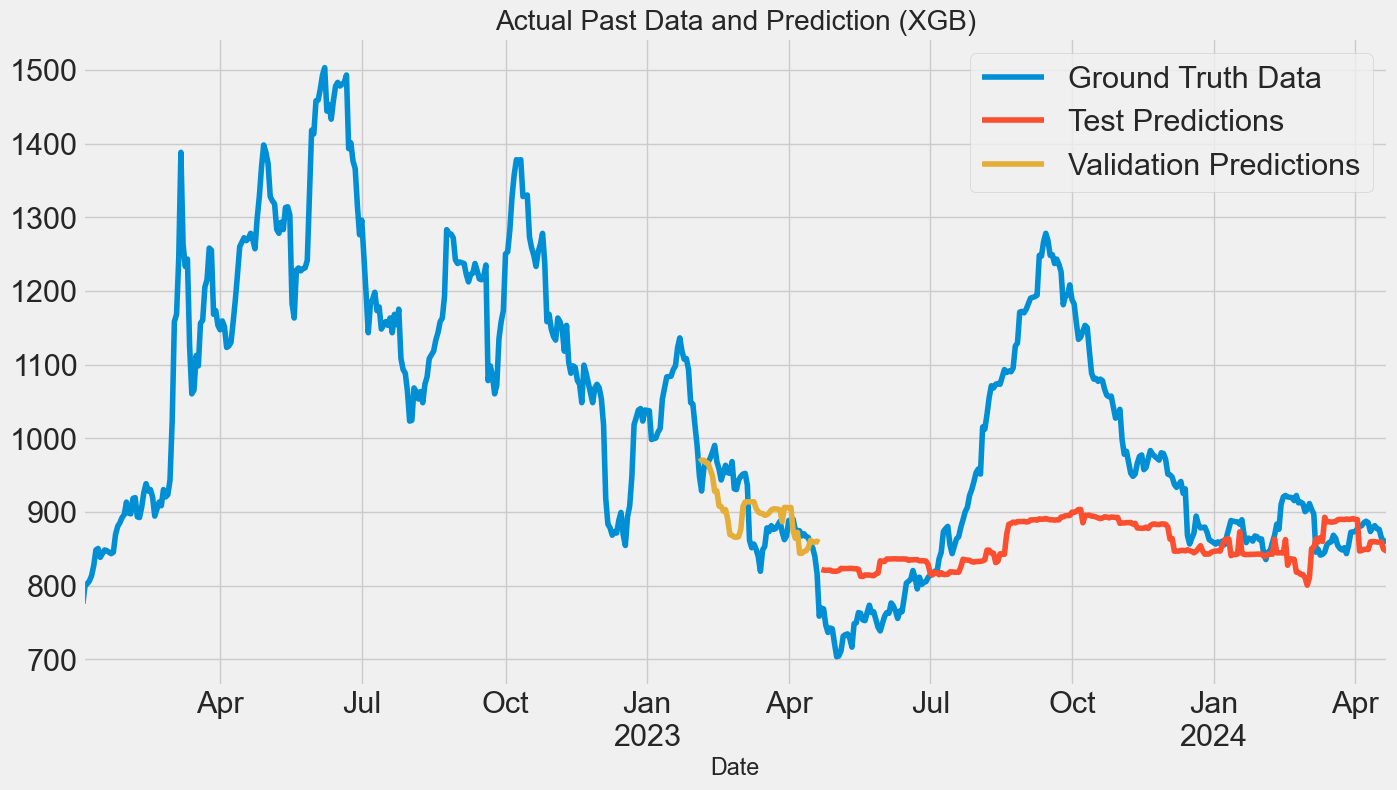

In [72]:
ax = ts['Marine Gasoil 9_Price'].plot(figsize=(15,8))
ts['prediction_xgb_ex5'].plot(ax=ax, style='-')
ts['prediction_xgb_val_ex5'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB)')
plt.show();

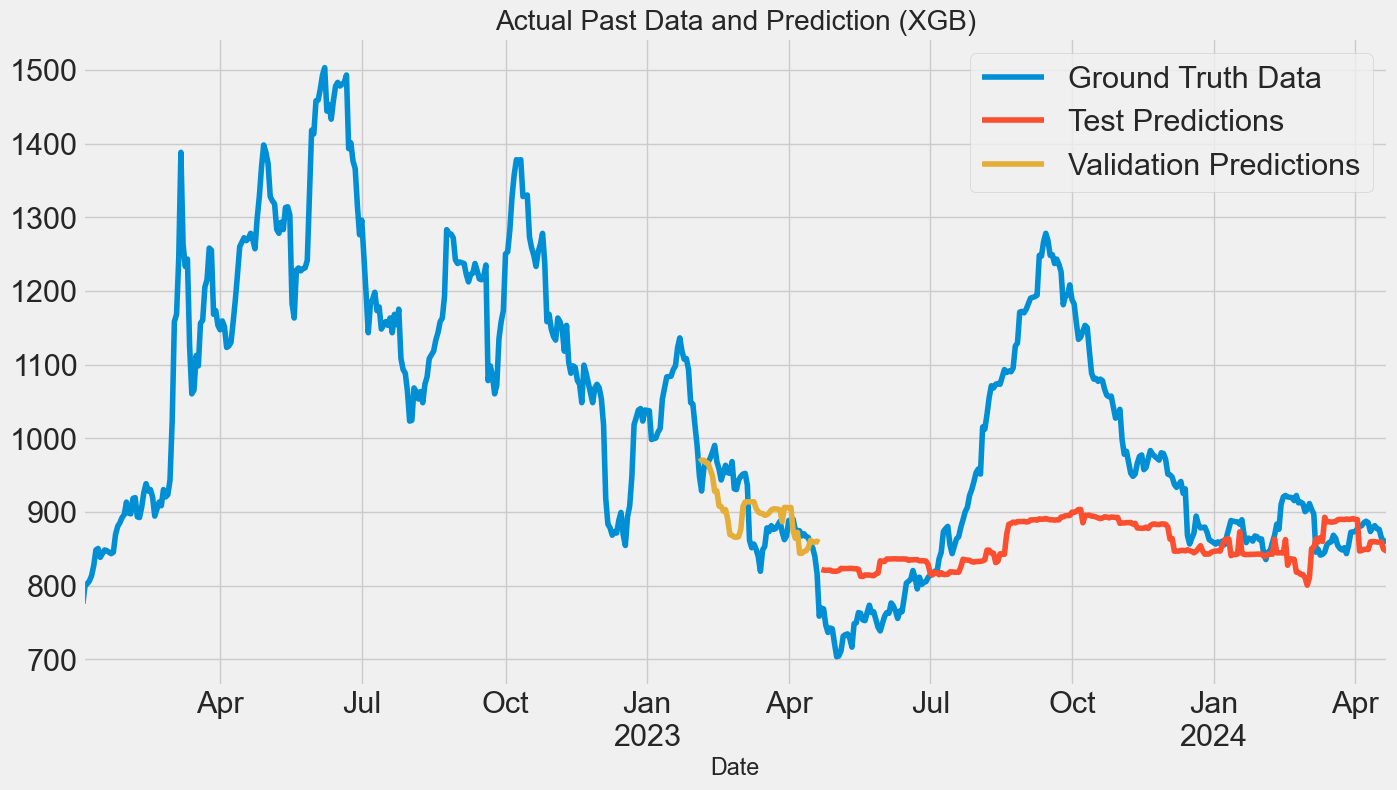

In [73]:
ax = ts['Marine Gasoil 9_Price'].plot(figsize=(15,8))
ts['prediction_xgb_ex5'].plot(ax=ax, style='-')
ts['prediction_xgb_val_ex5'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB)')
plt.show();

In [74]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

ts_clean = ts.dropna(subset=['prediction_xgb_val_ex5', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb_val = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_ex5'])
score_rmse_xgb_val = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_ex5']))
score_mape_xgb_val = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_ex5'])

# 결과 출력
print(f'MAE Score on Validation set (XGB): {score_mae_xgb_val:0.2f}')
print(f'RMSE Score on Validation set (XGB): {score_rmse_xgb_val:0.2f}')
print(f'MAPE Score on Validation set (XGB): {score_mape_xgb_val:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (XGB): 37.89
RMSE Score on Validation set (XGB): 45.16
MAPE Score on Validation set (XGB): 4.23%


In [75]:
ts_clean = ts.dropna(subset=['prediction_xgb_ex5', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_ex5'])
score_rmse_xgb = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_ex5']))
score_mape_xgb = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_ex5'])

# 결과 출력
print(f'MAE Score on Test set (XGB): {score_mae_xgb:0.2f}')
print(f'RMSE Score on Test set (XGB): {score_rmse_xgb:0.2f}')
print(f'MAPE Score on Test set (XGB): {score_mape_xgb:.2%}')  # 백분율 형식으로 출력

MAE Score on Test set (XGB): 101.48
RMSE Score on Test set (XGB): 140.40
MAPE Score on Test set (XGB): 9.99%


#### Shap

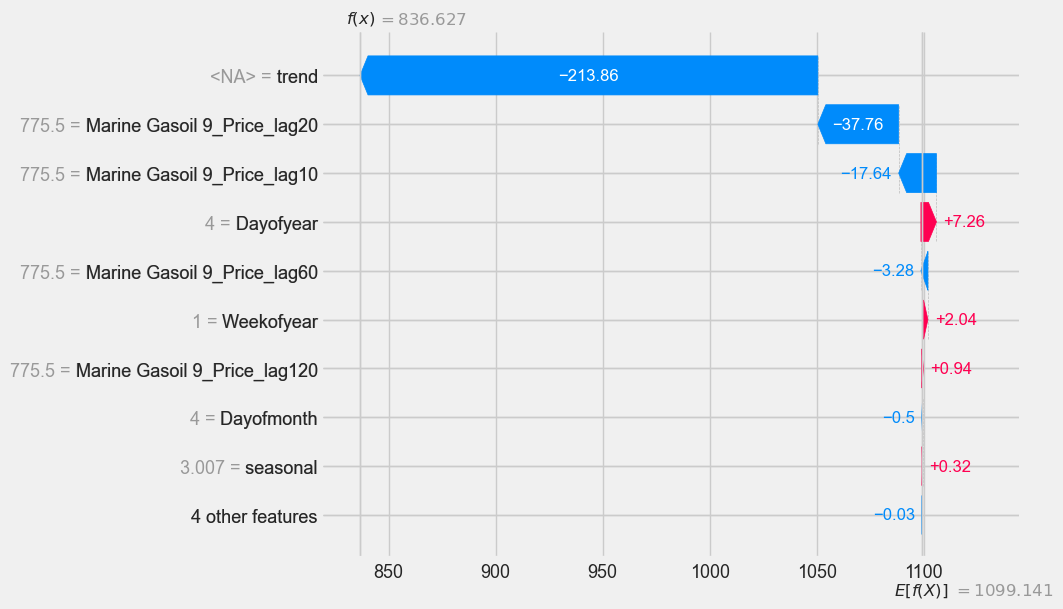

In [76]:
xgb_explainer = shap.Explainer(xgb_model)
shap_values_xgb = xgb_explainer.shap_values(X_test)

shap.initjs()
shap.waterfall_plot(shap.Explanation(values=shap_values_xgb[0],
                                     base_values=xgb_explainer.expected_value,
                                     data=X_train.iloc[0],
                                     feature_names=X_train.columns.tolist()))

## Exp 2. Cyclic

In [77]:
ts = pd.read_csv('05_MG9_ts.csv', index_col='Date')
ts.index = pd.to_datetime(ts.index)
ts = ts.asfreq('B')
ts = ts.interpolate(method='linear')

last_date = ts.index.max()

test_start_date = last_date - pd.Timedelta(days=365)  # 1년

train_val = ts.loc[ts.index <= test_start_date]
test = ts.loc[ts.index > test_start_date]

train_val['Year'] = train_val.index.year
train_val['Quarter'] = train_val.index.quarter
train_val['Month'] = train_val.index.month
train_val['Dayofweek'] = train_val.index.dayofweek
train_val['Dayofmonth'] = train_val.index.day
train_val['Weekofyear'] = train_val.index.isocalendar().week
train_val['Dayofyear'] = train_val.index.dayofyear

test['Year'] = test.index.year
test['Quarter'] = test.index.quarter
test['Month'] = test.index.month
test['Dayofweek'] = test.index.dayofweek
test['Dayofmonth'] = test.index.day
test['Weekofyear'] = test.index.isocalendar().week
test['Dayofyear'] = test.index.dayofyear

lag_days_list = [10, 20, 60, 120]

train_val = add_business_day_lags(train_val, 'Marine Gasoil 9_Price', lag_days_list)
test = add_business_day_lags(test, 'Marine Gasoil 9_Price', lag_days_list)

decomposition = seasonal_decompose(train_val['Marine Gasoil 9_Price'], period=20)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본 - 추세 - 계절성

train_val['trend'] = trend
train_val['seasonal'] = seasonal

In [78]:
# 주기적 반복 함수 정의
def apply_periodic_features(train_df, test_index, period):
    extended_features = {col: [] for col in train_df.columns}
    train_length = len(train_df)
    start_point = train_length - period
    for i, test_date in enumerate(test_index):
        index_in_period = (start_point + i) % train_length
        for col in train_df.columns:
            extended_features[col].append(train_df.iloc[index_in_period][col])
    return pd.DataFrame(extended_features, index=test_index)

# 주기 설정
period = 20

# Test 데이터에 대해 Trend와 Seasonal feature 적용
test_features = apply_periodic_features(train_val, test_dates, period)
test['trend'] = test_features['trend']
test['seasonal'] = test_features['seasonal']

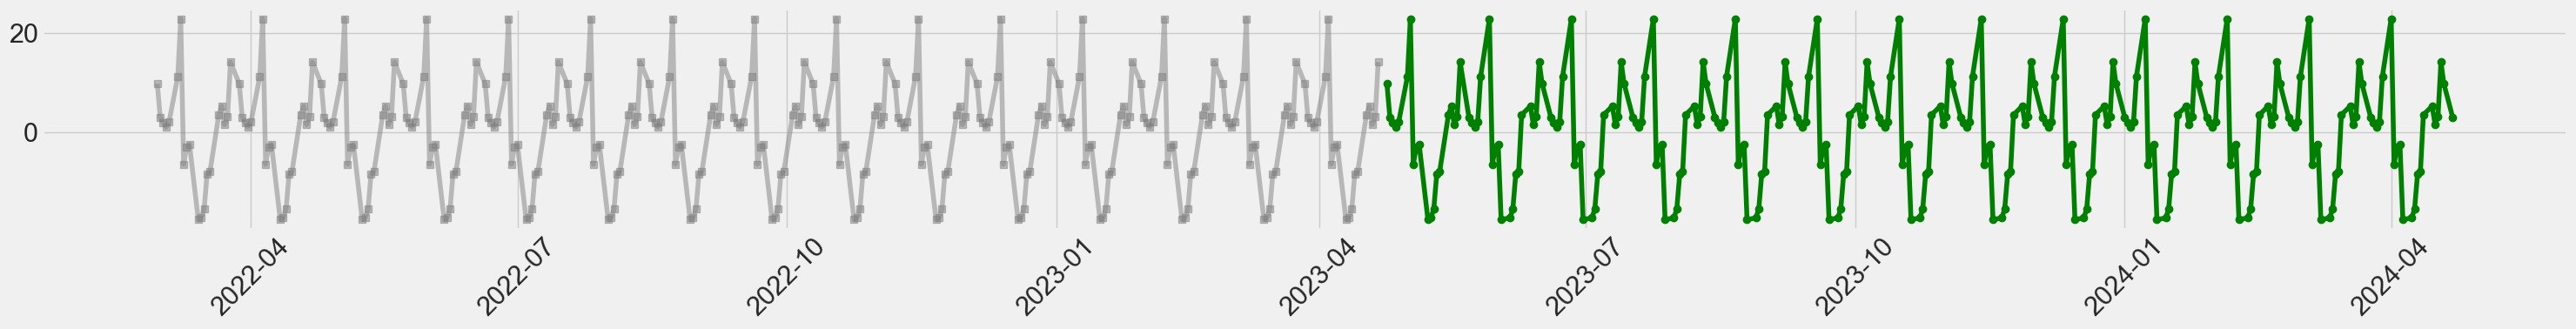

In [79]:
# 최근 300일 데이터 선택
recent_300_days = train_val.index[-300:]

# 결과 시각화
fig, ax = plt.subplots(figsize=(30, 4))

# 전체 train_val 데이터 시각화 (최근 300일 기준)
ax.plot(train_val.loc[recent_300_days].index, train_val.loc[recent_300_days]['seasonal'], 's-', color='grey', alpha=0.5, label='Seasonal Data')

# 테스트 데이터의 선 시각화
ax.plot(test.index, test['seasonal'], 'o-', color='green', label='Test Data')

# 중복 범례 제거
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# ax.legend(by_label.values(), by_label.keys())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [80]:
validation_start_date = test_start_date - pd.Timedelta(days=28)  # 주말 제외 20일이 되도록 조정 (주말 제외 한 달)

train = train_val.loc[train_val.index<=validation_start_date]
validation = train_val.loc[(train_val.index > validation_start_date) & (train_val.index <= test_start_date)]

train.shape, validation.shape, test.shape

((319, 14), (20, 14), (261, 14))

In [81]:
test = test.apply(pd.to_numeric, errors='coerce')
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2023-04-24 to 2024-04-22
Freq: B
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Marine Gasoil 9_Price         261 non-null    float64
 1   Year                          261 non-null    int32  
 2   Quarter                       261 non-null    int32  
 3   Month                         261 non-null    int32  
 4   Dayofweek                     261 non-null    int32  
 5   Dayofmonth                    261 non-null    int32  
 6   Weekofyear                    261 non-null    UInt32 
 7   Dayofyear                     261 non-null    int32  
 8   Marine Gasoil 9_Price_lag10   261 non-null    float64
 9   Marine Gasoil 9_Price_lag20   261 non-null    float64
 10  Marine Gasoil 9_Price_lag60   261 non-null    float64
 11  Marine Gasoil 9_Price_lag120  261 non-null    float64
 12  trend                         241 non

In [82]:
train['Weekofyear'] = train['Weekofyear'].astype('int32')
validation['Weekofyear'] = validation['Weekofyear'].astype('int32')
test['Weekofyear'] = test['Weekofyear'].astype('int32')

In [83]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_val = train_val.drop(columns=['Marine Gasoil 9_Price'])
y_train_val = train_val['Marine Gasoil 9_Price']
X_test = test.drop(columns=['Marine Gasoil 9_Price'])
y_test = test['Marine Gasoil 9_Price']

tss = TimeSeriesSplit(n_splits = 5)

mae_scores = []
rmse_scores = []
mape_scores = []

fold = 0
for train_idx, val_idx in tss.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)
    
    y_train_pred = xgb_model.predict(X_train)
    y_val_pred = xgb_model.predict(X_val)
    
    mae_scores.append(mean_absolute_error(y_val, y_val_pred))
    rmse_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))
    mape_scores.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)
    
    fold += 1

[0]	validation_0-rmse:1281.91503
[100]	validation_0-rmse:594.02699
[200]	validation_0-rmse:321.13697
[300]	validation_0-rmse:234.15080
[400]	validation_0-rmse:208.13216
[500]	validation_0-rmse:195.55245
[600]	validation_0-rmse:188.02300
[700]	validation_0-rmse:183.05563
[800]	validation_0-rmse:180.04318
[900]	validation_0-rmse:178.23731
[1000]	validation_0-rmse:177.04844
[1100]	validation_0-rmse:176.40775
[1200]	validation_0-rmse:175.84055
[1300]	validation_0-rmse:175.58073
[1400]	validation_0-rmse:175.36698
[1500]	validation_0-rmse:175.24609
[1600]	validation_0-rmse:175.15093
[1700]	validation_0-rmse:175.08929
[1800]	validation_0-rmse:175.05149
[1900]	validation_0-rmse:175.02520
[2000]	validation_0-rmse:175.00700
[2100]	validation_0-rmse:174.99551
[2200]	validation_0-rmse:174.98826
[2300]	validation_0-rmse:174.97995
[2400]	validation_0-rmse:174.97577
[2500]	validation_0-rmse:174.97324
[2600]	validation_0-rmse:174.97152
[2700]	validation_0-rmse:174.97041
[2800]	validation_0-rmse:174.96

In [84]:
# 성능 평가 지표 출력
print(f'MAE for each fold: {mae_scores}')
print(f'Average MAE across folds: {np.mean(mae_scores):0.2f}')

print(f'RMSE for each fold: {rmse_scores}')
print(f'Average RMSE across folds: {np.mean(rmse_scores):0.2f}')

print(f'MAPE for each fold: {mape_scores}')
print(f'Average MAPE across folds: {np.mean(mape_scores):0.2f}')

MAE for each fold: [149.44769723074776, 96.19344002859933, 44.506665910993306, 138.65599822998047, 37.88909912109375]
Average MAE across folds: 93.34
RMSE for each fold: [174.96796975769865, 115.21204944224395, 58.29274521319043, 163.77544146549891, 45.160544728136976]
Average RMSE across folds: 111.48
MAPE for each fold: [11.20554991937668, 7.87291615280532, 3.666298321473654, 13.83417534117998, 4.225264856091244]
Average MAPE across folds: 8.16


In [85]:
# 최종 모델 학습
xgb_model.fit(X_train, y_train,
                  eval_set = [(X_val, y_val)],
                  verbose=100)

[0]	validation_0-rmse:891.65557
[100]	validation_0-rmse:290.30734
[200]	validation_0-rmse:85.29314
[300]	validation_0-rmse:45.27427
[349]	validation_0-rmse:46.63754


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [86]:
pred_val = xgb_model.predict(X_val)
pred_test = xgb_model.predict(X_test)

pred_val_df = pd.DataFrame(pred_val, index=X_val.index, columns=['prediction_xgb_val_ex6'])
pred_test_df = pd.DataFrame(pred_test, index=X_test.index, columns=['prediction_xgb_ex6'])

ts = ts.merge(pred_val_df, how='left', left_index=True, right_index=True)
ts = ts.merge(pred_test_df, how='left', left_index=True, right_index=True)
ts

Marine Gasoil 9_Price  prediction_xgb_val_ex6  prediction_xgb_ex6
Date                                                                         
2022-01-04                  775.5                     NaN                 NaN
2022-01-05                  800.5                     NaN                 NaN
2022-01-06                  802.5                     NaN                 NaN
2022-01-07                  806.5                     NaN                 NaN
2022-01-10                  813.5                     NaN                 NaN
...                           ...                     ...                 ...
2024-04-16                  876.5                     NaN          960.423157
2024-04-17                  865.5                     NaN          958.599365
2024-04-18                  859.5                     NaN          950.888306
2024-04-19                  860.5                     NaN          940.102539
2024-04-22                  861.5                     NaN          935.103088

[600 rows x 3 columns]

#### Prediction

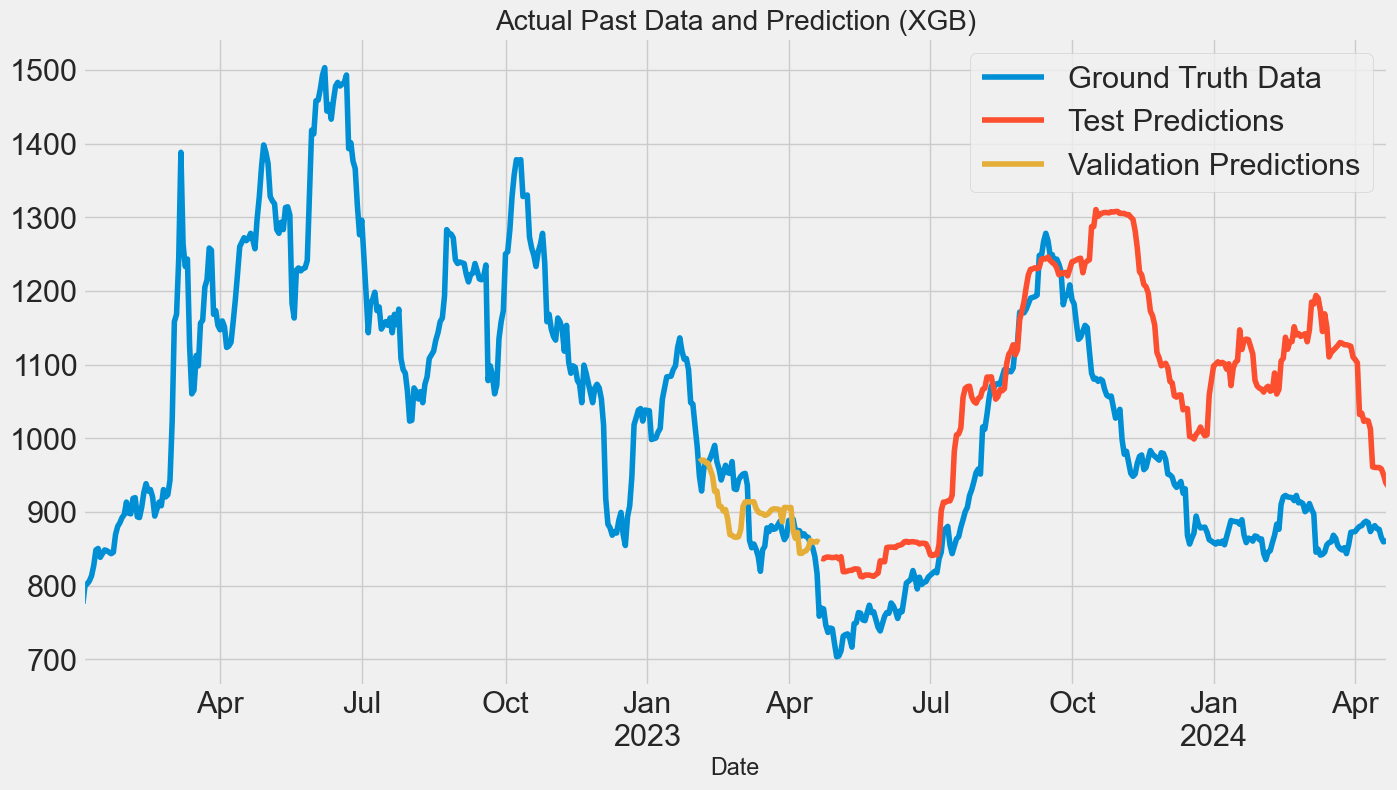

In [87]:
ax = ts['Marine Gasoil 9_Price'].plot(figsize=(15,8))
ts['prediction_xgb_ex6'].plot(ax=ax, style='-')
ts['prediction_xgb_val_ex6'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB)')
plt.show();

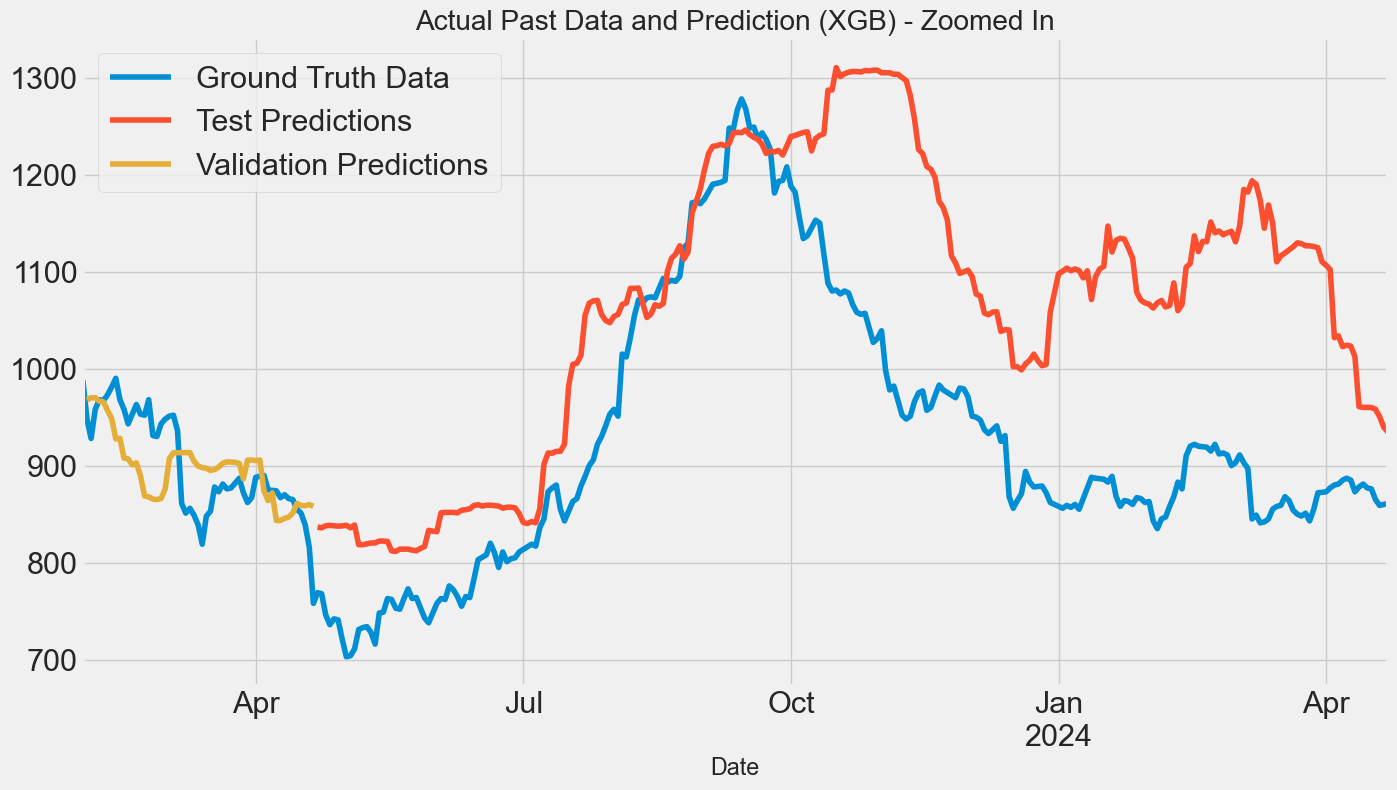

In [88]:
# 특정 날짜 범위를 지정하여 확대
start_date = '2023-02-02'
end_date = '2024-05-01'

# 데이터 필터링
ts_zoomed = ts.loc[start_date:end_date]

# 확대된 범위의 그래프 그리기
ax = ts_zoomed['Marine Gasoil 9_Price'].plot(figsize=(15, 8))
ts_zoomed['prediction_xgb_ex6'].plot(ax=ax, style='-')
ts_zoomed['prediction_xgb_val_ex6'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB) - Zoomed In')
plt.show()

#### MAE, RMSE, MAPE

In [89]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

ts_clean = ts.dropna(subset=['prediction_xgb_val_ex6', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb_val = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_ex6'])
score_rmse_xgb_val = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_ex6']))
score_mape_xgb_val = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_ex6'])

# 결과 출력
print(f'MAE Score on Validation set (XGB): {score_mae_xgb_val:0.2f}')
print(f'RMSE Score on Validation set (XGB): {score_rmse_xgb_val:0.2f}')
print(f'MAPE Score on Validation set (XGB): {score_mape_xgb_val:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (XGB): 37.89
RMSE Score on Validation set (XGB): 45.16
MAPE Score on Validation set (XGB): 4.23%


In [91]:
ts_clean = ts.dropna(subset=['prediction_xgb_ex6', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_ex6'])
score_rmse_xgb = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_ex6']))
score_mape_xgb = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_ex6'])

# 결과 출력
print(f'MAE Score on Test set (XGB): {score_mae_xgb:0.2f}')
print(f'RMSE Score on Test set (XGB): {score_rmse_xgb:0.2f}')
print(f'MAPE Score on Test set (XGB): {score_mape_xgb:.2%}')  # 백분율 형식으로 출력

MAE Score on Test set (XGB): 140.67
RMSE Score on Test set (XGB): 169.17
MAPE Score on Test set (XGB): 15.67%


#### Shap

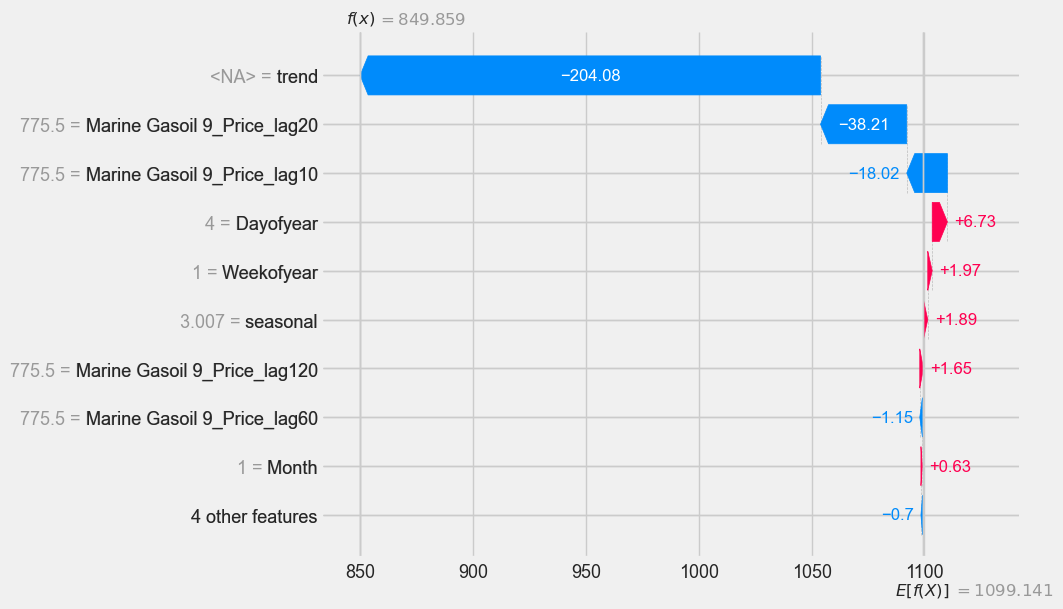

In [92]:
xgb_explainer = shap.Explainer(xgb_model)
shap_values_xgb = xgb_explainer.shap_values(X_test)

shap.initjs()
shap.waterfall_plot(shap.Explanation(values=shap_values_xgb[0],
                                     base_values=xgb_explainer.expected_value,
                                     data=X_train.iloc[0],
                                     feature_names=X_train.columns.tolist()))